In [ ]:
from model import TrainableModel
from config import load_config
import pytorch_lightning as pl
from pytorch_lightning.plugins import DDPPlugin

from datasets.fairface import FairFaceDataModule
import os
os.environ["PL_TORCH_DISTRIBUTED_BACKEND"] = "gloo"

config_path = r"F:\Lab\nfs\nsl\final\configs\base_config.json"
PATH = r"F:\Lab\nfs\nsl\final\training-run\lightning_logs\version_31\checkpoints\epoch=11-step=2039.ckpt"

model = TrainableModel.load_from_checkpoint(PATH)

trainer = pl.Trainer(
        devices=[0, 1],
        accelerator="gpu",
        strategy=DDPPlugin(find_unused_parameters=False),
        precision=16,
        benchmark=True,
    )

data = FairFaceDataModule(load_config(config_path), filter_by=None)
trainer.test(model, data)

In [ ]:
results = [['East Asian-Male', [{'val_loss': 0.2998589873313904, 'val_acc': 0.9434447288513184}]], ['Indian-Female', [{'val_loss': 0.31293296813964844, 'val_acc': 0.9253926873207092}]], ['Black-Female', [{'val_loss': 0.42313945293426514, 'val_acc': 0.8601583242416382}]], ['White-Male', [{'val_loss': 0.2750524878501892, 'val_acc': 0.958110511302948}]], ['Middle Eastern-Male', [{'val_loss': 0.24184180796146393, 'val_acc': 0.974201500415802}]], ['Latino_Hispanic-Male', [{'val_loss': 0.28150424361228943, 'val_acc': 0.9521410465240479}]], ['Indian-Male', [{'val_loss': 0.2652071416378021, 'val_acc': 0.9562334418296814}]], ['White-Female', [{'val_loss': 0.3157532811164856, 'val_acc': 0.9315352439880371}]], ['Southeast Asian-Female', [{'val_loss': 0.30571621656417847, 'val_acc': 0.9352940917015076}]], ['Southeast Asian-Male', [{'val_loss': 0.32584166526794434, 'val_acc': 0.9334239363670349}]], ['Middle Eastern-Female', [{'val_loss': 0.2906527519226074, 'val_acc': 0.939393937587738}]], ['East Asian-Female', [{'val_loss': 0.3152497112751007, 'val_acc': 0.9354005455970764}]], ['Latino_Hispanic-Female', [{'val_loss': 0.26993653178215027, 'val_acc': 0.9674698710441589}]], ['Black-Male', [{'val_loss': 0.34034624695777893, 'val_acc': 0.9137499928474426}]]]
[['East Asian-Male', [{'val_loss': 0.2998589873313904, 'val_acc': 0.9434447288513184}]], ['Indian-Female', [{'val_loss': 0.31293296813964844, 'val_acc': 0.9253926873207092}]], ['Black-Female', [{'val_loss': 0.42313945293426514, 'val_acc': 0.8601583242416382}]], ['White-Male', [{'val_loss': 0.2750524878501892, 'val_acc': 0.958110511302948}]], ['Middle Eastern-Male', [{'val_loss': 0.24184180796146393, 'val_acc': 0.974201500415802}]], ['Latino_Hispanic-Male', [{'val_loss': 0.28150424361228943, 'val_acc': 0.9521410465240479}]], ['Indian-Male', [{'val_loss': 0.2652071416378021, 'val_acc': 0.9562334418296814}]], ['White-Female', [{'val_loss': 0.3157532811164856, 'val_acc': 0.9315352439880371}]], ['Southeast Asian-Female', [{'val_loss': 0.30571621656417847, 'val_acc': 0.9352940917015076}]], ['Southeast Asian-Male', [{'val_loss': 0.32584166526794434, 'val_acc': 0.9334239363670349}]], ['Middle Eastern-Female', [{'val_loss': 0.2906527519226074, 'val_acc': 0.939393937587738}]], ['East Asian-Female', [{'val_loss': 0.3152497112751007, 'val_acc': 0.9354005455970764}]], ['Latino_Hispanic-Female', [{'val_loss': 0.26993653178215027, 'val_acc': 0.9674698710441589}]], ['Black-Male', [{'val_loss': 0.34034624695777893, 'val_acc': 0.9137499928474426}]]]

male_acc = []
female_acc = []

for acc in results:
    if acc[0].split("-")[1] == "Male":
        male_acc.append(acc[1][0]['val_acc'] * 100)
    else:
        female_acc.append(acc[1][0]['val_acc'] * 100)

In [131]:
from model import TrainableModel
from config import load_config
import pytorch_lightning as pl
from pytorch_lightning.plugins import DDPPlugin

from datasets.fairface import FairFaceDataModule
import os
from glob import glob
os.environ["PL_TORCH_DISTRIBUTED_BACKEND"] = "gloo"

config_path = r"F:\Lab\nfs\nsl\final\configs\base_config.json"

PATH = r"F:\Lab\nfs\nsl\final\training-run\lightning_logs\version_163\checkpoints\*"

import torch
import pandas as pd
import numpy as np
results = {}
for f in glob(PATH):
    result = []
    model = TrainableModel.load_from_checkpoint(f, config=load_config(config_path))

    trainer = pl.Trainer(
            devices=[0],
            accelerator="gpu",
            strategy=DDPPlugin(find_unused_parameters=False),
            precision=16,
            benchmark=True,
        )

    accs = []
    for race_gender in ['East Asian-Male', 'Indian-Female', 'Black-Female', 'White-Male', 'Middle Eastern-Male', 'Latino_Hispanic-Male', 'Indian-Male', 'White-Female', 'Southeast Asian-Female', 'Southeast Asian-Male', 'Middle Eastern-Female', 'East Asian-Female', 'Latino_Hispanic-Female', 'Black-Male']:
        data = FairFaceDataModule(load_config(config_path), filter_by=race_gender)
        acc = trainer.test(model, data)
        accs.append([race_gender, acc])


    acc = []
    total = 0
    for f in glob(r"F:\Lab\nfs\nsl\final\*.csv"):
        df = pd.read_csv(f)
        acc.append(len(df[df.correct == 1]) / len(df))
        total += len(df)

    import numpy as np
    print(np.array(acc).std())

    result.append([acc, np.array(acc).std()])

    acc = []
    percent = []
    for i in np.arange(0, 1, 0.05):
        for f in glob(r"F:\Lab\nfs\nsl\final\*.csv"):
            df = pd.read_csv(f)
            df_ = df[df.uncertainty < i]
            percent.append(len(df_) / len(df))
            acc.append(len(df_[df_.correct == 1]) / len(df_))


        min_ = np.array(percent).min()
        std = np.array(acc).std()
        result.append([i, min_, std])

    results[f] = result
    break
print(results)

AttributeError: module 'pytorch_lightning' has no attribute 'utilities'

In [ ]:

for f in glob(r"F:\Lab\nfs\nsl\final\*.csv"):
    df = pd.read_csv(f)
    df_ = df[df.uncertainty < 0.35]
    percent.append(len(df_) / len(df))
    acc.append(len(df_[df_.correct == 1]) / len(df_))


In [130]:
{
    "F:\\Lab\\nfs\\nsl\\training-run\\lightning_logs\\version_28\\checkpoints\\epoch=11-val_std=2.2812.ckpt": [
        [
            [
                0.8784676354029062,
                0.9148936170212766,
                0.943078913324709,
                0.9330759330759331,
                0.9423328964613368,
                0.9575033200531209,
                0.9506024096385542,
                0.9457755359394704,
                0.9368686868686869,
                0.9790897908979089,
                0.9367647058823529,
                0.9346938775510204,
                0.9335410176531672,
                0.9554367201426025,
            ],
            0.021982442054372543,
            0.9394741646886982,
        ],
        [0.0, 0.0, 0.0],
        [0.05, 0.5878467635402906, 0.015283222677675321],
        [0.1, 0.797886393659181, 0.015146615627509087],
        [0.15000000000000002, 0.8467635402906208, 0.01613134300915324],
        [0.2, 0.8784676354029062, 0.01654592849902108],
        [0.25, 0.8956406869220608, 0.01718087170815456],
        [0.30000000000000004, 0.9141347424042272, 0.018057651804846343],
        [0.35000000000000003, 0.9260237780713342, 0.01878936685625301],
        [0.4, 0.9326287978863936, 0.01956381858458404],
        [0.45, 0.9484808454425363, 0.020187759611437896],
        [0.5, 0.9564068692206077, 0.021012267065631158],
        [0.55, 0.9646464646464646, 0.021250981225664538],
        [0.6000000000000001, 0.9722222222222222, 0.021615587349328166],
        [0.65, 0.9920739762219286, 0.022057677501821752],
        [0.7000000000000001, 0.9962453066332916, 0.021934460397613032],
        [0.75, 1.0, 0.021982442054372543],
        [0.8, 1.0, 0.021982442054372543],
        [0.8500000000000001, 1.0, 0.021982442054372543],
        [0.9, 1.0, 0.021982442054372543],
        [0.9500000000000001, 1.0, 0.021982442054372543],
    ],
    "F:\\Lab\\nfs\\nsl\\training-run\\lightning_logs\\version_28\\checkpoints\\epoch=24-val_std=2.2360.ckpt": [
        [
            [
                0.8824306472919419,
                0.9173967459324155,
                0.9573091849935317,
                0.9227799227799228,
                0.9554390563564875,
                0.9468791500664011,
                0.963855421686747,
                0.9319041614123581,
                0.9545454545454546,
                0.968019680196802,
                0.9470588235294117,
                0.926530612244898,
                0.940809968847352,
                0.9393939393939394,
            ],
            0.02166012937046812,
            0.9392915829833851,
        ],
        [0.0, 0.0, 0.0],
        [0.05, 0.8150594451783355, 0.014390789866110578],
        [0.1, 0.8599735799207398, 0.016771952659057548],
        [0.15000000000000002, 0.8771466314398944, 0.01669022556195679],
        [0.2, 0.8916776750330251, 0.017925559025931567],
        [0.25, 0.9062087186261559, 0.019081225407886166],
        [0.30000000000000004, 0.9128137384412153, 0.019605715720443933],
        [0.35000000000000003, 0.916776750330251, 0.019160149434126],
        [0.4, 0.9247027741083224, 0.020009387487367927],
        [0.45, 0.9339498018494056, 0.020681310395310723],
        [0.5, 0.9484808454425363, 0.021727863604985687],
        [0.55, 0.9550858652575958, 0.021936597220143964],
        [0.6000000000000001, 0.9749009247027741, 0.022074058882677813],
        [0.65, 0.9867899603698811, 0.02198206184904257],
        [0.7000000000000001, 0.9947159841479525, 0.022264205705917542],
        [0.75, 0.99734395750332, 0.021759641756448206],
        [0.8, 1.0, 0.02166012937046812],
        [0.8500000000000001, 1.0, 0.02166012937046812],
        [0.9, 1.0, 0.02166012937046812],
        [0.9500000000000001, 1.0, 0.02166012937046812],
    ],
    "F:\\Lab\\nfs\\nsl\\training-run\\lightning_logs\\version_28\\checkpoints\\epoch=37-val_std=2.2695.ckpt": [
        [
            [
                0.8850726552179656,
                0.9061326658322904,
                0.9547218628719275,
                0.9214929214929215,
                0.9397116644823067,
                0.949535192563081,
                0.9614457831325302,
                0.9369482976040353,
                0.9621212121212122,
                0.966789667896679,
                0.95,
                0.9319727891156463,
                0.9376947040498442,
                0.9393939393939394,
            ],
            0.021778236976780566,
            0.9381048018988497,
        ],
        [0.0, 0.0, 0.0],
        [0.05, 0.8969616908850726, 0.017625344882275976],
        [0.1, 0.9141347424042272, 0.01785975999494116],
        [0.15000000000000002, 0.9207397622192867, 0.018292462846081284],
        [0.2, 0.9273447820343461, 0.018560661242937787],
        [0.25, 0.9352708058124174, 0.0183831706659678],
        [0.30000000000000004, 0.9418758256274768, 0.019298513373927382],
        [0.35000000000000003, 0.9458388375165125, 0.0198868611627858],
        [0.4, 0.9498018494055482, 0.020047370191248727],
        [0.45, 0.9511228533685601, 0.0198415668997561],
        [0.5, 0.9550858652575958, 0.01993239818779451],
        [0.55, 0.9564068692206077, 0.019863966683074455],
        [0.6000000000000001, 0.9630118890356671, 0.020566039211739735],
        [0.65, 0.9682959048877147, 0.02031012299614538],
        [0.7000000000000001, 0.9749009247027741, 0.020773058506653244],
        [0.75, 0.9815059445178336, 0.021385942554103973],
        [0.8, 0.988110964332893, 0.02142846999222325],
        [0.8500000000000001, 0.9960369881109643, 0.021677570650969615],
        [0.9, 0.998639455782313, 0.021686550741285716],
        [0.9500000000000001, 1.0, 0.021778236976780566],
    ],
    "F:\\Lab\\nfs\\nsl\\training-run\\lightning_logs\\version_28\\checkpoints\\epoch=51-val_std=2.3320.ckpt": [
        [
            [
                0.8705416116248349,
                0.9198998748435544,
                0.943078913324709,
                0.9420849420849421,
                0.9475753604193972,
                0.9548472775564409,
                0.9530120481927711,
                0.9520807061790668,
                0.9494949494949495,
                0.972939729397294,
                0.9411764705882353,
                0.9414965986394558,
                0.9335410176531672,
                0.946524064171123,
            ],
            0.02250962737412051,
            0.940569654920577,
        ],
        [0.0, 0.0, 0.0],
        [0.05, 0.8190224570673712, 0.016990614209991328],
        [0.1, 0.8586525759577279, 0.017723816410417512],
        [0.15000000000000002, 0.8797886393659181, 0.017551553088255026],
        [0.2, 0.8956406869220608, 0.0175559615269555],
        [0.25, 0.9075297225891678, 0.017510592287505726],
        [0.30000000000000004, 0.9194187582562747, 0.01772503376823523],
        [0.35000000000000003, 0.9273447820343461, 0.018491311882387944],
        [0.4, 0.9299867899603699, 0.018762073790036065],
        [0.45, 0.9326287978863936, 0.01845058676822341],
        [0.5, 0.9392338177014531, 0.018579596360176958],
        [0.55, 0.9431968295904888, 0.019040347303772683],
        [0.6000000000000001, 0.9511228533685601, 0.019740406583539448],
        [0.65, 0.9561952440550688, 0.01987710228643362],
        [0.7000000000000001, 0.9624530663329162, 0.020143146826618576],
        [0.75, 0.9699624530663329, 0.021096017512262737],
        [0.8, 0.9774718397997497, 0.021658117663188325],
        [0.8500000000000001, 0.986232790988736, 0.021537733460285587],
        [0.9, 0.9987484355444305, 0.02243577115756141],
        [0.9500000000000001, 1.0, 0.02250962737412051],
    ],
    "F:\\Lab\\nfs\\nsl\\training-run\\lightning_logs\\version_28\\checkpoints\\epoch=52-val_std=2.0583.ckpt": [
        [
            [
                0.9180977542932629,
                0.8948685857321652,
                0.9521345407503234,
                0.9343629343629344,
                0.9567496723460026,
                0.9322709163346613,
                0.9626506024096385,
                0.9319041614123581,
                0.9671717171717171,
                0.964329643296433,
                0.9514705882352941,
                0.9197278911564626,
                0.9418483904465212,
                0.9385026737967914,
            ],
            0.019803021104285345,
            0.9395654555413547,
        ],
        [0.0, 0.0, 0.0],
        [0.05, 0.8423028785982478, 0.017267355677075713],
        [0.1, 0.8903566710700133, 0.017878470213637927],
        [0.15000000000000002, 0.904887714663144, 0.017953004658880178],
        [0.2, 0.9128137384412153, 0.018314275082607183],
        [0.25, 0.9154557463672391, 0.0180614837342484],
        [0.30000000000000004, 0.9260237780713342, 0.017832114169785786],
        [0.35000000000000003, 0.9339498018494056, 0.018536304202031856],
        [0.4, 0.9365918097754293, 0.018213675364478064],
        [0.45, 0.9392338177014531, 0.018523558397169283],
        [0.5, 0.9484808454425363, 0.018441641339262],
        [0.55, 0.9574468085106383, 0.018170310601276718],
        [0.6000000000000001, 0.9630118890356671, 0.018559219615255602],
        [0.65, 0.9669749009247027, 0.01884068920286017],
        [0.7000000000000001, 0.9735799207397622, 0.01913849894757045],
        [0.75, 0.9774718397997497, 0.019176449675722233],
        [0.8, 0.9874843554443054, 0.019051983767425104],
        [0.8500000000000001, 0.9960681520314548, 0.01986325183910743],
        [0.9, 1.0, 0.019803021104285345],
        [0.9500000000000001, 1.0, 0.019803021104285345],
    ],
    "F:\\Lab\\nfs\\nsl\\training-run\\lightning_logs\\version_28\\checkpoints\\epoch=53-val_std=2.0884.ckpt": [
        [
            [
                0.9022457067371202,
                0.8986232790988736,
                0.9469598965071151,
                0.9433719433719434,
                0.9593709043250328,
                0.9375830013280213,
                0.9602409638554217,
                0.9344262295081968,
                0.9595959595959596,
                0.974169741697417,
                0.9470588235294117,
                0.9360544217687075,
                0.9460020768431984,
                0.948306595365419,
            ],
            0.020104088651351278,
            0.942212890268395,
        ],
        [0.0, 0.0, 0.0],
        [0.05, 0.8652575957727873, 0.013671910403318005],
        [0.1, 0.8850726552179656, 0.015426393994875106],
        [0.15000000000000002, 0.9009247027741083, 0.015342292084972384],
        [0.2, 0.9128137384412153, 0.015811924096995916],
        [0.25, 0.9180977542932629, 0.015702910478358017],
        [0.30000000000000004, 0.9299867899603699, 0.016672927066622878],
        [0.35000000000000003, 0.9365918097754293, 0.016903618578807105],
        [0.4, 0.9484808454425363, 0.016800670030502642],
        [0.45, 0.9564068692206077, 0.017394589631214357],
        [0.5, 0.9577278731836195, 0.017340964511577097],
        [0.55, 0.9616908850726552, 0.018295982264481366],
        [0.6000000000000001, 0.9682959048877147, 0.018482029239934666],
        [0.65, 0.9762219286657859, 0.018806532858011864],
        [0.7000000000000001, 0.9828269484808454, 0.018699976131236057],
        [0.75, 0.9933949801849405, 0.01960531214590027],
        [0.8, 0.9974747474747475, 0.020097866130734592],
        [0.8500000000000001, 1.0, 0.020104088651351278],
        [0.9, 1.0, 0.020104088651351278],
        [0.9500000000000001, 1.0, 0.020104088651351278],
    ],
    "F:\\Lab\\nfs\\nsl\\training-run\\lightning_logs\\version_28\\checkpoints\\epoch=59-val_std=2.1044.ckpt": [
        [
            [
                0.8890356671070013,
                0.9123904881101377,
                0.9391979301423027,
                0.9601029601029601,
                0.9462647444298821,
                0.953519256308101,
                0.9542168674698795,
                0.9419924337957125,
                0.9494949494949495,
                0.976629766297663,
                0.9352941176470588,
                0.9414965986394558,
                0.9397715472481828,
                0.9536541889483066,
            ],
            0.020278805230786914,
            0.9426693445316779,
        ],
        [0.0, 0.0, 0.0],
        [0.05, 0.8507265521796565, 0.012537829427750457],
        [0.1, 0.8943196829590488, 0.015365574847008755],
        [0.15000000000000002, 0.9075297225891678, 0.015695609918801232],
        [0.2, 0.9141347424042272, 0.015148273054250233],
        [0.25, 0.9207397622192867, 0.0156457632853899],
        [0.30000000000000004, 0.9273447820343461, 0.016088339882742338],
        [0.35000000000000003, 0.9365918097754293, 0.01586861240383496],
        [0.4, 0.9445178335535006, 0.016922774405562373],
        [0.45, 0.9537648612945839, 0.01757030517542891],
        [0.5, 0.9603698811096433, 0.018259482979311698],
        [0.55, 0.9656538969616909, 0.01895050580116419],
        [0.6000000000000001, 0.9749009247027741, 0.01911262422046948],
        [0.65, 0.9841479524438573, 0.019483278286548684],
        [0.7000000000000001, 0.9947159841479525, 0.020418564095432315],
        [0.75, 0.9986893840104849, 0.020330817519390473],
        [0.8, 0.9986893840104849, 0.020298390651601144],
        [0.8500000000000001, 1.0, 0.020278805230786914],
        [0.9, 1.0, 0.020278805230786914],
        [0.9500000000000001, 1.0, 0.020278805230786914],
    ],
    "F:\\Lab\\nfs\\nsl\\training-run\\lightning_logs\\version_28\\checkpoints\\epoch=67-val_std=1.9321.ckpt": [
        [
            [
                0.9035667107001321,
                0.9061326658322904,
                0.943078913324709,
                0.9498069498069498,
                0.9436435124508519,
                0.9575033200531209,
                0.9554216867469879,
                0.9445145018915511,
                0.9621212121212122,
                0.971709717097171,
                0.9455882352941176,
                0.9414965986394558,
                0.9314641744548287,
                0.9572192513368984,
            ],
            0.018618155053767644,
            0.943490962205587,
        ],
        [0.0, 0.0, 0.0],
        [0.05, 0.8058124174372523, 0.014590312946067972],
        [0.1, 0.8494055482166446, 0.015785896776933688],
        [0.15000000000000002, 0.8718626155878467, 0.016645345631803227],
        [0.2, 0.8890356671070013, 0.016894228418924215],
        [0.25, 0.9022457067371202, 0.017084090298585347],
        [0.30000000000000004, 0.9088507265521797, 0.0171356404122323],
        [0.35000000000000003, 0.9141347424042272, 0.017094487159640417],
        [0.4, 0.916776750330251, 0.01710953151025972],
        [0.45, 0.9233817701453104, 0.01698785357667415],
        [0.5, 0.9299867899603699, 0.016735332679234265],
        [0.55, 0.9339498018494056, 0.016588951560583334],
        [0.6000000000000001, 0.9365918097754293, 0.016513069214812055],
        [0.65, 0.9458388375165125, 0.017180847453739805],
        [0.7000000000000001, 0.9484808454425363, 0.017498777551079255],
        [0.75, 0.9590488771466315, 0.017655213534254314],
        [0.8, 0.9682959048877147, 0.01720485145186926],
        [0.8500000000000001, 0.9815059445178336, 0.01784633890700559],
        [0.9, 0.9960369881109643, 0.018781209643165864],
        [0.9500000000000001, 1.0, 0.018618155053767644],
    ],
    "F:\\Lab\\nfs\\nsl\\training-run\\lightning_logs\\version_28\\checkpoints\\epoch=68-val_std=2.2799.ckpt": [
        [
            [
                0.8824306472919419,
                0.9173967459324155,
                0.9469598965071151,
                0.9498069498069498,
                0.9567496723460026,
                0.949535192563081,
                0.9650602409638555,
                0.9432534678436317,
                0.9671717171717171,
                0.97539975399754,
                0.9426470588235294,
                0.9401360544217687,
                0.9376947040498442,
                0.9447415329768271,
            ],
            0.02197008981917697,
            0.9435822530582436,
        ],
        [0.0, 0.0, 0.0],
        [0.05, 0.8863936591809776, 0.01606978388103256],
        [0.1, 0.9180977542932629, 0.01802271817595685],
        [0.15000000000000002, 0.9260237780713342, 0.01852072840418101],
        [0.2, 0.9392338177014531, 0.019103421917634686],
        [0.25, 0.9431968295904888, 0.01943189712653218],
        [0.30000000000000004, 0.9537648612945839, 0.020141431605375865],
        [0.35000000000000003, 0.9603698811096433, 0.01996869895603092],
        [0.4, 0.964332892998679, 0.020117012960040048],
        [0.45, 0.9656538969616909, 0.0200829018984798],
        [0.5, 0.9735799207397622, 0.020064320056366266],
        [0.55, 0.9762219286657859, 0.01996366503415633],
        [0.6000000000000001, 0.9841479524438573, 0.020979593052799284],
        [0.65, 0.9907529722589168, 0.021208847896924655],
        [0.7000000000000001, 0.9985294117647059, 0.021997553877367296],
        [0.75, 1.0, 0.02197008981917697],
        [0.8, 1.0, 0.02197008981917697],
        [0.8500000000000001, 1.0, 0.02197008981917697],
        [0.9, 1.0, 0.02197008981917697],
        [0.9500000000000001, 1.0, 0.02197008981917697],
    ],
    "F:\\Lab\\nfs\\nsl\\training-run\\lightning_logs\\version_28\\checkpoints\\epoch=70-val_std=2.2449.ckpt": [
        [
            [
                0.8903566710700133,
                0.904881101376721,
                0.9417852522639069,
                0.9498069498069498,
                0.9475753604193972,
                0.9575033200531209,
                0.9566265060240964,
                0.9470365699873896,
                0.9595959595959596,
                0.977859778597786,
                0.9426470588235294,
                0.9292517006802721,
                0.9314641744548287,
                0.9500891265597148,
            ],
            0.021632204374832185,
            0.9415738542997991,
        ],
        [0.0, 0.0, 0.0],
        [0.05, 0.7952443857331571, 0.01333727834290398],
        [0.1, 0.8494055482166446, 0.01384375556913777],
        [0.15000000000000002, 0.8771466314398944, 0.015293799984200662],
        [0.2, 0.8877146631439894, 0.015483918149749535],
        [0.25, 0.8916776750330251, 0.015138251059894565],
        [0.30000000000000004, 0.9011264080100125, 0.016571193110856905],
        [0.35000000000000003, 0.9036295369211514, 0.01657607349941559],
        [0.4, 0.9111389236545682, 0.016760671174801418],
        [0.45, 0.9148936170212766, 0.016883139382791307],
        [0.5, 0.9161451814768461, 0.017197859770962515],
        [0.55, 0.9224030037546934, 0.017638464271385077],
        [0.6000000000000001, 0.9274092615769712, 0.01786490539086778],
        [0.65, 0.932415519399249, 0.01753975914556772],
        [0.7000000000000001, 0.9386733416770964, 0.017866772255178652],
        [0.75, 0.9461827284105131, 0.018077178465537545],
        [0.8, 0.951188986232791, 0.01886228300344134],
        [0.8500000000000001, 0.9599499374217773, 0.018957956178444972],
        [0.9, 0.9709379128137384, 0.01985461831856519],
        [0.9500000000000001, 0.9867197875166003, 0.021106066916000737],
    ],
}


In [47]:
import yaml
import json
s = json.dumps(dict(yaml.load(open(r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_23\hparams.yaml"), Loader=yaml.Loader))['config'], default=lambda o: o.__dict__, 
            sort_keys=True, indent=4)

with open('temp_eval_config.json', 'w') as f:
    f.write(s)

In [5]:
import cv2
from tqdm import tqdm
from glob import glob

for f in tqdm(glob(r"F:\Lab\datasets\fairface\fairface-img-margin025-trainval\neighbors\*.jpg")):
    img = cv2.imread(f)
    img = cv2.resize(img, (224, 224))
    # Save image
    cv2.imwrite(f, img)

100%|██████████| 607208/607208 [2:15:12<00:00, 74.85it/s]  


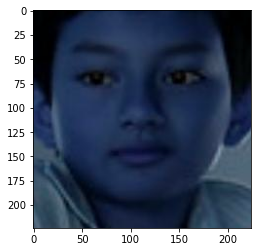

In [31]:
import cv2
from turbojpeg import TurboJPEG, TJPF_GRAY, TJSAMP_GRAY, TJFLAG_PROGRESSIVE, TJFLAG_FASTUPSAMPLE, TJFLAG_FASTDCT

# specifying library path explicitly
# jpeg = TurboJPEG(r'D:\turbojpeg.dll')
# jpeg = TurboJPEG('/usr/lib64/libturbojpeg.so')
# jpeg = TurboJPEG('/usr/local/lib/libturbojpeg.dylib')

# using default library installation
jpeg = TurboJPEG()

# decoding input.jpg to BGR array
in_file = open(r"F:\Lab\datasets\fairface\fairface-img-margin025-trainval\val\1.jpg", 'rb')
bgr_array = jpeg.decode(in_file.read())
im_rgb = cv2.cvtColor(bgr_array, cv2.COLOR_BGR2RGB)

import matplotlib.pyplot as plt

plt.imshow(bgr_array)

In [2]:
from turbojpeg import TurboJPEG

jpeg = TurboJPEG()

from glob import glob
from tqdm import tqdm   
images = []
for f in tqdm(glob(r"F:\Lab\datasets\fairface\fairface-img-margin025-trainval\neighbors\*.jpg")):
    in_file = open(f, 'rb')
    img = jpeg.decode(in_file.read())
    images.append(img)
    in_file.close()


100%|██████████| 607208/607208 [16:28<00:00, 613.96it/s] 


In [11]:
import webdataset as wds

url = "file:F:/Lab/datasets/fairface/fairface-img-margin025-trainval/neighbors.tar"

dataset  = wds.WebDataset(url).decode("torchrgb").to_tuple("jpg", "0.jpg", "1.jpg", "2.jpg", "3.jpg", "4.jpg", "5.jpg", "6.jpg")

In [21]:

from itertools import islice

dataset

In [146]:
# Evaluate UTKFace

path = r"F:\Lab\datasets\UTKFace\*"

ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_104\checkpoints\epoch=58-val_std=2.0966.ckpt" # Baseline
ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_105\checkpoints\epoch=76-val_std=1.9868.ckpt" # MT
ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_106\checkpoints\epoch=8-val_std=1.8177.ckpt" # MT + NSL
ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_108\checkpoints\epoch=67-val_std=1.7028.ckpt" # MT + NSL + EDL
ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_122\checkpoints\epoch=42-val_std=1.9463.ckpt" # NSL

YAML_PATH = '\\'.join(ckpt_path.split("\\")[0:-2]) + "\\hparams.yaml"
print(YAML_PATH)

import yaml
config = dict(yaml.load(open(YAML_PATH), Loader=yaml.Loader))['config']

import cv2
from model import TrainableModel

from glob import glob
from tqdm import tqdm
from torchvision import transforms
import dlib
from turbojpeg import TurboJPEG
import torch
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor(r"C:\Users\g728v562\Downloads\shape_predictor_5_face_landmarks.dat\shape_predictor_5_face_landmarks.dat")
jpeg = TurboJPEG()
device = 'cuda'
with_dlib = False
batch_size = 512
transform = transforms.Compose([
            transforms.ToPILImage(),  
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4824, 0.3578, 0.3045],
                                 std=[0.2571, 0.2242, 0.2182])
        ])

model = TrainableModel.load_from_checkpoint(ckpt_path, config=config).to(device)
model.eval()

paths = 

for RACE in range(5):
    for GENDER in range(2):
        images = []

        y_pred = []
        y_true = []
        paths = [x for x in glob(path) if int(x.split("\\")[-1].split("_")[2]) == RACE]
        paths = [x for x in paths if int(x.split("\\")[-1].split("_")[1]) == GENDER]

        paths = glob(path) # Overall


        length = len(paths)
        for i, img in enumerate(tqdm(paths)):
            in_file = open(img, 'rb')
            images.append(cv2.cvtColor(jpeg.decode(in_file.read()), cv2.COLOR_BGR2RGB))
            label = int((img.split("\\")[-1].split("_")[1]) == "0")
            y_true.append(label)
            in_file.close()

            # dets = detector(img, 1)
            # faces = dlib.full_object_detections()

            # for detection in dets:
            #     faces.append(sp(img, detection))
            


            if len(images) == batch_size or i == length - 1:
                images = torch.stack([transform(image) for image in images])
                images = images.to(device)
                with torch.no_grad():
                    outputs = model(images)
                    # outputs = outputs[0]
                    y_pred.extend(outputs)
                images = []


        #
        y_pred = torch.stack(y_pred).cpu()
        y_true = torch.tensor(y_true).cpu()
        from torchmetrics.functional import accuracy,confusion_matrix
        # print(y_pred.shape, y_true.shape)
        acc = accuracy(y_pred.argmax(1), y_true)

        print(RACE, GENDER, acc)

F:\Lab\nfs\nsl\training-run\lightning_logs\version_122\hparams.yaml


100%|██████████| 23705/23705 [00:58<00:00, 404.28it/s]


0 0 tensor(0.9440)


 30%|███       | 7167/23705 [00:20<00:47, 348.84it/s]


KeyboardInterrupt: 

In [1]:
# Evaluate DiveFace

path = r"C:\Users\g728v562\Documents\datasets\DiveFace\\"

ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_104\checkpoints\epoch=58-val_std=2.0966.ckpt" # Baseline
ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_105\checkpoints\epoch=76-val_std=1.9868.ckpt" # MT
ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_106\checkpoints\epoch=8-val_std=1.8177.ckpt" # MT + NSL
ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_108\checkpoints\epoch=67-val_std=1.7028.ckpt" # MT + NSL + EDL
ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_122\checkpoints\epoch=42-val_std=1.9463.ckpt" # NSL

ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_166\checkpoints\epoch=83-val_std=0.1827.ckpt" # Trained on DiveFace (MT + NSL)
ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_168\checkpoints\epoch=66-val_std=0.2486.ckpt" # Trained on DiveFace (Baseline)

ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_183\checkpoints\epoch=43-val_std=1.1185.ckpt" # CLIP linear probe
# ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_188\checkpoints\epoch=38-val_std=1.0888.ckpt" # CLIP linear probe + NSL

YAML_PATH = '\\'.join(ckpt_path.split("\\")[0:-2]) + "\\hparams.yaml"
print(YAML_PATH)

import yaml
config = dict(yaml.load(open(YAML_PATH), Loader=yaml.Loader))['config']

import cv2
from model import TrainableModel

from glob import glob
from tqdm import tqdm
from torchvision import transforms
import dlib
from turbojpeg import TurboJPEG
import torch
import pandas as pd
import numpy as np

# detector = dlib.get_frontal_face_detector()
# sp = dlib.shape_predictor(r"C:\Users\g728v562\Downloads\shape_predictor_5_face_landmarks.dat\shape_predictor_5_face_landmarks.dat")
jpeg = TurboJPEG()
device = 'cuda'
with_dlib = False
batch_size = 128
transform = transforms.Compose([
            transforms.ToPILImage(),  
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4824, 0.3578, 0.3045],
                                 std=[0.2571, 0.2242, 0.2182])
        ])

model = TrainableModel.load_from_checkpoint(ckpt_path, config=config).to(device)
model.eval()

df = pd.read_csv(r"C:\Users\g728v562\Documents\datasets\DiveFace\diveface_all.csv")
from sklearn.model_selection import train_test_split
_, df = train_test_split(df, test_size=0.2, random_state=42)

accs = []
overall_y_pred = []
overall_y_true = []
for RACE in ["East Asian", "Sub-Saharan and South Indian", "White"]:
    df_ = df[df.race == RACE]
    for GENDER in ["Male", "Female"]:
        df_n = df_[df_.gender == GENDER]
        images = []

        y_pred = []
        y_true = []


        # paths = glob(path + RACE + "\\" + GENDER + "\\*")
        paths = list(df_n.file)
        paths = [os.path.join(r"C:\Users\g728v562\Documents\datasets\DiveFace\All", x) for x in paths]

        

        length = len(paths)
        for i, img in enumerate(tqdm(paths)):
            in_file = open(img, 'rb')
            images.append(cv2.cvtColor(jpeg.decode(in_file.read()), cv2.COLOR_BGR2RGB))
            label = int(GENDER == "Male")
            y_true.append(label)
            overall_y_true.append(label)
            in_file.close()

            # dets = detector(img, 1)
            # faces = dlib.full_object_detections()

            # for detection in dets:
            #     faces.append(sp(img, detection))
            


            if len(images) == batch_size or i == length - 1:
                images = torch.stack([transform(image) for image in images])
                images = images.to(device)
                with torch.no_grad():
                    outputs = model(images)
                    # outputs = outputs[0]
                    y_pred.extend(outputs)
                    overall_y_pred.extend(outputs)
                images = []


        y_pred = torch.stack(y_pred).cpu()
        y_true = torch.tensor(y_true).cpu()
        from torchmetrics.functional import accuracy,confusion_matrix
        # print(y_pred.shape, y_true.shape)
        acc = accuracy(y_pred.argmax(1), y_true)

        print(RACE, GENDER, acc)
        accs.append(acc)

print(np.std(np.array(accs)) * 100) 

y_pred = torch.stack(overall_y_pred).cpu()
y_true = torch.tensor(overall_y_true).cpu()
# print(y_pred.shape, y_true.shape)
acc = accuracy(y_pred.argmax(1), y_true)
print(acc)

F:\Lab\nfs\nsl\training-run\lightning_logs\version_183\hparams.yaml


RuntimeError: Error(s) in loading state_dict for TrainableModel:
	Missing key(s) in state_dict: "base_model.conv_stem.weight", "base_model.bn1.weight", "base_model.bn1.bias", "base_model.bn1.running_mean", "base_model.bn1.running_var", "base_model.blocks.0.0.conv.weight", "base_model.blocks.0.0.bn1.weight", "base_model.blocks.0.0.bn1.bias", "base_model.blocks.0.0.bn1.running_mean", "base_model.blocks.0.0.bn1.running_var", "base_model.blocks.0.1.conv.weight", "base_model.blocks.0.1.bn1.weight", "base_model.blocks.0.1.bn1.bias", "base_model.blocks.0.1.bn1.running_mean", "base_model.blocks.0.1.bn1.running_var", "base_model.blocks.0.2.conv.weight", "base_model.blocks.0.2.bn1.weight", "base_model.blocks.0.2.bn1.bias", "base_model.blocks.0.2.bn1.running_mean", "base_model.blocks.0.2.bn1.running_var", "base_model.blocks.0.3.conv.weight", "base_model.blocks.0.3.bn1.weight", "base_model.blocks.0.3.bn1.bias", "base_model.blocks.0.3.bn1.running_mean", "base_model.blocks.0.3.bn1.running_var", "base_model.blocks.1.0.conv_exp.weight", "base_model.blocks.1.0.bn1.weight", "base_model.blocks.1.0.bn1.bias", "base_model.blocks.1.0.bn1.running_mean", "base_model.blocks.1.0.bn1.running_var", "base_model.blocks.1.0.conv_pwl.weight", "base_model.blocks.1.0.bn2.weight", "base_model.blocks.1.0.bn2.bias", "base_model.blocks.1.0.bn2.running_mean", "base_model.blocks.1.0.bn2.running_var", "base_model.blocks.1.1.conv_exp.weight", "base_model.blocks.1.1.bn1.weight", "base_model.blocks.1.1.bn1.bias", "base_model.blocks.1.1.bn1.running_mean", "base_model.blocks.1.1.bn1.running_var", "base_model.blocks.1.1.conv_pwl.weight", "base_model.blocks.1.1.bn2.weight", "base_model.blocks.1.1.bn2.bias", "base_model.blocks.1.1.bn2.running_mean", "base_model.blocks.1.1.bn2.running_var", "base_model.blocks.1.2.conv_exp.weight", "base_model.blocks.1.2.bn1.weight", "base_model.blocks.1.2.bn1.bias", "base_model.blocks.1.2.bn1.running_mean", "base_model.blocks.1.2.bn1.running_var", "base_model.blocks.1.2.conv_pwl.weight", "base_model.blocks.1.2.bn2.weight", "base_model.blocks.1.2.bn2.bias", "base_model.blocks.1.2.bn2.running_mean", "base_model.blocks.1.2.bn2.running_var", "base_model.blocks.1.3.conv_exp.weight", "base_model.blocks.1.3.bn1.weight", "base_model.blocks.1.3.bn1.bias", "base_model.blocks.1.3.bn1.running_mean", "base_model.blocks.1.3.bn1.running_var", "base_model.blocks.1.3.conv_pwl.weight", "base_model.blocks.1.3.bn2.weight", "base_model.blocks.1.3.bn2.bias", "base_model.blocks.1.3.bn2.running_mean", "base_model.blocks.1.3.bn2.running_var", "base_model.blocks.1.4.conv_exp.weight", "base_model.blocks.1.4.bn1.weight", "base_model.blocks.1.4.bn1.bias", "base_model.blocks.1.4.bn1.running_mean", "base_model.blocks.1.4.bn1.running_var", "base_model.blocks.1.4.conv_pwl.weight", "base_model.blocks.1.4.bn2.weight", "base_model.blocks.1.4.bn2.bias", "base_model.blocks.1.4.bn2.running_mean", "base_model.blocks.1.4.bn2.running_var", "base_model.blocks.1.5.conv_exp.weight", "base_model.blocks.1.5.bn1.weight", "base_model.blocks.1.5.bn1.bias", "base_model.blocks.1.5.bn1.running_mean", "base_model.blocks.1.5.bn1.running_var", "base_model.blocks.1.5.conv_pwl.weight", "base_model.blocks.1.5.bn2.weight", "base_model.blocks.1.5.bn2.bias", "base_model.blocks.1.5.bn2.running_mean", "base_model.blocks.1.5.bn2.running_var", "base_model.blocks.1.6.conv_exp.weight", "base_model.blocks.1.6.bn1.weight", "base_model.blocks.1.6.bn1.bias", "base_model.blocks.1.6.bn1.running_mean", "base_model.blocks.1.6.bn1.running_var", "base_model.blocks.1.6.conv_pwl.weight", "base_model.blocks.1.6.bn2.weight", "base_model.blocks.1.6.bn2.bias", "base_model.blocks.1.6.bn2.running_mean", "base_model.blocks.1.6.bn2.running_var", "base_model.blocks.2.0.conv_exp.weight", "base_model.blocks.2.0.bn1.weight", "base_model.blocks.2.0.bn1.bias", "base_model.blocks.2.0.bn1.running_mean", "base_model.blocks.2.0.bn1.running_var", "base_model.blocks.2.0.conv_pwl.weight", "base_model.blocks.2.0.bn2.weight", "base_model.blocks.2.0.bn2.bias", "base_model.blocks.2.0.bn2.running_mean", "base_model.blocks.2.0.bn2.running_var", "base_model.blocks.2.1.conv_exp.weight", "base_model.blocks.2.1.bn1.weight", "base_model.blocks.2.1.bn1.bias", "base_model.blocks.2.1.bn1.running_mean", "base_model.blocks.2.1.bn1.running_var", "base_model.blocks.2.1.conv_pwl.weight", "base_model.blocks.2.1.bn2.weight", "base_model.blocks.2.1.bn2.bias", "base_model.blocks.2.1.bn2.running_mean", "base_model.blocks.2.1.bn2.running_var", "base_model.blocks.2.2.conv_exp.weight", "base_model.blocks.2.2.bn1.weight", "base_model.blocks.2.2.bn1.bias", "base_model.blocks.2.2.bn1.running_mean", "base_model.blocks.2.2.bn1.running_var", "base_model.blocks.2.2.conv_pwl.weight", "base_model.blocks.2.2.bn2.weight", "base_model.blocks.2.2.bn2.bias", "base_model.blocks.2.2.bn2.running_mean", "base_model.blocks.2.2.bn2.running_var", "base_model.blocks.2.3.conv_exp.weight", "base_model.blocks.2.3.bn1.weight", "base_model.blocks.2.3.bn1.bias", "base_model.blocks.2.3.bn1.running_mean", "base_model.blocks.2.3.bn1.running_var", "base_model.blocks.2.3.conv_pwl.weight", "base_model.blocks.2.3.bn2.weight", "base_model.blocks.2.3.bn2.bias", "base_model.blocks.2.3.bn2.running_mean", "base_model.blocks.2.3.bn2.running_var", "base_model.blocks.2.4.conv_exp.weight", "base_model.blocks.2.4.bn1.weight", "base_model.blocks.2.4.bn1.bias", "base_model.blocks.2.4.bn1.running_mean", "base_model.blocks.2.4.bn1.running_var", "base_model.blocks.2.4.conv_pwl.weight", "base_model.blocks.2.4.bn2.weight", "base_model.blocks.2.4.bn2.bias", "base_model.blocks.2.4.bn2.running_mean", "base_model.blocks.2.4.bn2.running_var", "base_model.blocks.2.5.conv_exp.weight", "base_model.blocks.2.5.bn1.weight", "base_model.blocks.2.5.bn1.bias", "base_model.blocks.2.5.bn1.running_mean", "base_model.blocks.2.5.bn1.running_var", "base_model.blocks.2.5.conv_pwl.weight", "base_model.blocks.2.5.bn2.weight", "base_model.blocks.2.5.bn2.bias", "base_model.blocks.2.5.bn2.running_mean", "base_model.blocks.2.5.bn2.running_var", "base_model.blocks.2.6.conv_exp.weight", "base_model.blocks.2.6.bn1.weight", "base_model.blocks.2.6.bn1.bias", "base_model.blocks.2.6.bn1.running_mean", "base_model.blocks.2.6.bn1.running_var", "base_model.blocks.2.6.conv_pwl.weight", "base_model.blocks.2.6.bn2.weight", "base_model.blocks.2.6.bn2.bias", "base_model.blocks.2.6.bn2.running_mean", "base_model.blocks.2.6.bn2.running_var", "base_model.blocks.3.0.conv_pw.weight", "base_model.blocks.3.0.bn1.weight", "base_model.blocks.3.0.bn1.bias", "base_model.blocks.3.0.bn1.running_mean", "base_model.blocks.3.0.bn1.running_var", "base_model.blocks.3.0.conv_dw.weight", "base_model.blocks.3.0.bn2.weight", "base_model.blocks.3.0.bn2.bias", "base_model.blocks.3.0.bn2.running_mean", "base_model.blocks.3.0.bn2.running_var", "base_model.blocks.3.0.se.conv_reduce.weight", "base_model.blocks.3.0.se.conv_reduce.bias", "base_model.blocks.3.0.se.conv_expand.weight", "base_model.blocks.3.0.se.conv_expand.bias", "base_model.blocks.3.0.conv_pwl.weight", "base_model.blocks.3.0.bn3.weight", "base_model.blocks.3.0.bn3.bias", "base_model.blocks.3.0.bn3.running_mean", "base_model.blocks.3.0.bn3.running_var", "base_model.blocks.3.1.conv_pw.weight", "base_model.blocks.3.1.bn1.weight", "base_model.blocks.3.1.bn1.bias", "base_model.blocks.3.1.bn1.running_mean", "base_model.blocks.3.1.bn1.running_var", "base_model.blocks.3.1.conv_dw.weight", "base_model.blocks.3.1.bn2.weight", "base_model.blocks.3.1.bn2.bias", "base_model.blocks.3.1.bn2.running_mean", "base_model.blocks.3.1.bn2.running_var", "base_model.blocks.3.1.se.conv_reduce.weight", "base_model.blocks.3.1.se.conv_reduce.bias", "base_model.blocks.3.1.se.conv_expand.weight", "base_model.blocks.3.1.se.conv_expand.bias", "base_model.blocks.3.1.conv_pwl.weight", "base_model.blocks.3.1.bn3.weight", "base_model.blocks.3.1.bn3.bias", "base_model.blocks.3.1.bn3.running_mean", "base_model.blocks.3.1.bn3.running_var", "base_model.blocks.3.2.conv_pw.weight", "base_model.blocks.3.2.bn1.weight", "base_model.blocks.3.2.bn1.bias", "base_model.blocks.3.2.bn1.running_mean", "base_model.blocks.3.2.bn1.running_var", "base_model.blocks.3.2.conv_dw.weight", "base_model.blocks.3.2.bn2.weight", "base_model.blocks.3.2.bn2.bias", "base_model.blocks.3.2.bn2.running_mean", "base_model.blocks.3.2.bn2.running_var", "base_model.blocks.3.2.se.conv_reduce.weight", "base_model.blocks.3.2.se.conv_reduce.bias", "base_model.blocks.3.2.se.conv_expand.weight", "base_model.blocks.3.2.se.conv_expand.bias", "base_model.blocks.3.2.conv_pwl.weight", "base_model.blocks.3.2.bn3.weight", "base_model.blocks.3.2.bn3.bias", "base_model.blocks.3.2.bn3.running_mean", "base_model.blocks.3.2.bn3.running_var", "base_model.blocks.3.3.conv_pw.weight", "base_model.blocks.3.3.bn1.weight", "base_model.blocks.3.3.bn1.bias", "base_model.blocks.3.3.bn1.running_mean", "base_model.blocks.3.3.bn1.running_var", "base_model.blocks.3.3.conv_dw.weight", "base_model.blocks.3.3.bn2.weight", "base_model.blocks.3.3.bn2.bias", "base_model.blocks.3.3.bn2.running_mean", "base_model.blocks.3.3.bn2.running_var", "base_model.blocks.3.3.se.conv_reduce.weight", "base_model.blocks.3.3.se.conv_reduce.bias", "base_model.blocks.3.3.se.conv_expand.weight", "base_model.blocks.3.3.se.conv_expand.bias", "base_model.blocks.3.3.conv_pwl.weight", "base_model.blocks.3.3.bn3.weight", "base_model.blocks.3.3.bn3.bias", "base_model.blocks.3.3.bn3.running_mean", "base_model.blocks.3.3.bn3.running_var", "base_model.blocks.3.4.conv_pw.weight", "base_model.blocks.3.4.bn1.weight", "base_model.blocks.3.4.bn1.bias", "base_model.blocks.3.4.bn1.running_mean", "base_model.blocks.3.4.bn1.running_var", "base_model.blocks.3.4.conv_dw.weight", "base_model.blocks.3.4.bn2.weight", "base_model.blocks.3.4.bn2.bias", "base_model.blocks.3.4.bn2.running_mean", "base_model.blocks.3.4.bn2.running_var", "base_model.blocks.3.4.se.conv_reduce.weight", "base_model.blocks.3.4.se.conv_reduce.bias", "base_model.blocks.3.4.se.conv_expand.weight", "base_model.blocks.3.4.se.conv_expand.bias", "base_model.blocks.3.4.conv_pwl.weight", "base_model.blocks.3.4.bn3.weight", "base_model.blocks.3.4.bn3.bias", "base_model.blocks.3.4.bn3.running_mean", "base_model.blocks.3.4.bn3.running_var", "base_model.blocks.3.5.conv_pw.weight", "base_model.blocks.3.5.bn1.weight", "base_model.blocks.3.5.bn1.bias", "base_model.blocks.3.5.bn1.running_mean", "base_model.blocks.3.5.bn1.running_var", "base_model.blocks.3.5.conv_dw.weight", "base_model.blocks.3.5.bn2.weight", "base_model.blocks.3.5.bn2.bias", "base_model.blocks.3.5.bn2.running_mean", "base_model.blocks.3.5.bn2.running_var", "base_model.blocks.3.5.se.conv_reduce.weight", "base_model.blocks.3.5.se.conv_reduce.bias", "base_model.blocks.3.5.se.conv_expand.weight", "base_model.blocks.3.5.se.conv_expand.bias", "base_model.blocks.3.5.conv_pwl.weight", "base_model.blocks.3.5.bn3.weight", "base_model.blocks.3.5.bn3.bias", "base_model.blocks.3.5.bn3.running_mean", "base_model.blocks.3.5.bn3.running_var", "base_model.blocks.3.6.conv_pw.weight", "base_model.blocks.3.6.bn1.weight", "base_model.blocks.3.6.bn1.bias", "base_model.blocks.3.6.bn1.running_mean", "base_model.blocks.3.6.bn1.running_var", "base_model.blocks.3.6.conv_dw.weight", "base_model.blocks.3.6.bn2.weight", "base_model.blocks.3.6.bn2.bias", "base_model.blocks.3.6.bn2.running_mean", "base_model.blocks.3.6.bn2.running_var", "base_model.blocks.3.6.se.conv_reduce.weight", "base_model.blocks.3.6.se.conv_reduce.bias", "base_model.blocks.3.6.se.conv_expand.weight", "base_model.blocks.3.6.se.conv_expand.bias", "base_model.blocks.3.6.conv_pwl.weight", "base_model.blocks.3.6.bn3.weight", "base_model.blocks.3.6.bn3.bias", "base_model.blocks.3.6.bn3.running_mean", "base_model.blocks.3.6.bn3.running_var", "base_model.blocks.3.7.conv_pw.weight", "base_model.blocks.3.7.bn1.weight", "base_model.blocks.3.7.bn1.bias", "base_model.blocks.3.7.bn1.running_mean", "base_model.blocks.3.7.bn1.running_var", "base_model.blocks.3.7.conv_dw.weight", "base_model.blocks.3.7.bn2.weight", "base_model.blocks.3.7.bn2.bias", "base_model.blocks.3.7.bn2.running_mean", "base_model.blocks.3.7.bn2.running_var", "base_model.blocks.3.7.se.conv_reduce.weight", "base_model.blocks.3.7.se.conv_reduce.bias", "base_model.blocks.3.7.se.conv_expand.weight", "base_model.blocks.3.7.se.conv_expand.bias", "base_model.blocks.3.7.conv_pwl.weight", "base_model.blocks.3.7.bn3.weight", "base_model.blocks.3.7.bn3.bias", "base_model.blocks.3.7.bn3.running_mean", "base_model.blocks.3.7.bn3.running_var", "base_model.blocks.3.8.conv_pw.weight", "base_model.blocks.3.8.bn1.weight", "base_model.blocks.3.8.bn1.bias", "base_model.blocks.3.8.bn1.running_mean", "base_model.blocks.3.8.bn1.running_var", "base_model.blocks.3.8.conv_dw.weight", "base_model.blocks.3.8.bn2.weight", "base_model.blocks.3.8.bn2.bias", "base_model.blocks.3.8.bn2.running_mean", "base_model.blocks.3.8.bn2.running_var", "base_model.blocks.3.8.se.conv_reduce.weight", "base_model.blocks.3.8.se.conv_reduce.bias", "base_model.blocks.3.8.se.conv_expand.weight", "base_model.blocks.3.8.se.conv_expand.bias", "base_model.blocks.3.8.conv_pwl.weight", "base_model.blocks.3.8.bn3.weight", "base_model.blocks.3.8.bn3.bias", "base_model.blocks.3.8.bn3.running_mean", "base_model.blocks.3.8.bn3.running_var", "base_model.blocks.3.9.conv_pw.weight", "base_model.blocks.3.9.bn1.weight", "base_model.blocks.3.9.bn1.bias", "base_model.blocks.3.9.bn1.running_mean", "base_model.blocks.3.9.bn1.running_var", "base_model.blocks.3.9.conv_dw.weight", "base_model.blocks.3.9.bn2.weight", "base_model.blocks.3.9.bn2.bias", "base_model.blocks.3.9.bn2.running_mean", "base_model.blocks.3.9.bn2.running_var", "base_model.blocks.3.9.se.conv_reduce.weight", "base_model.blocks.3.9.se.conv_reduce.bias", "base_model.blocks.3.9.se.conv_expand.weight", "base_model.blocks.3.9.se.conv_expand.bias", "base_model.blocks.3.9.conv_pwl.weight", "base_model.blocks.3.9.bn3.weight", "base_model.blocks.3.9.bn3.bias", "base_model.blocks.3.9.bn3.running_mean", "base_model.blocks.3.9.bn3.running_var", "base_model.blocks.4.0.conv_pw.weight", "base_model.blocks.4.0.bn1.weight", "base_model.blocks.4.0.bn1.bias", "base_model.blocks.4.0.bn1.running_mean", "base_model.blocks.4.0.bn1.running_var", "base_model.blocks.4.0.conv_dw.weight", "base_model.blocks.4.0.bn2.weight", "base_model.blocks.4.0.bn2.bias", "base_model.blocks.4.0.bn2.running_mean", "base_model.blocks.4.0.bn2.running_var", "base_model.blocks.4.0.se.conv_reduce.weight", "base_model.blocks.4.0.se.conv_reduce.bias", "base_model.blocks.4.0.se.conv_expand.weight", "base_model.blocks.4.0.se.conv_expand.bias", "base_model.blocks.4.0.conv_pwl.weight", "base_model.blocks.4.0.bn3.weight", "base_model.blocks.4.0.bn3.bias", "base_model.blocks.4.0.bn3.running_mean", "base_model.blocks.4.0.bn3.running_var", "base_model.blocks.4.1.conv_pw.weight", "base_model.blocks.4.1.bn1.weight", "base_model.blocks.4.1.bn1.bias", "base_model.blocks.4.1.bn1.running_mean", "base_model.blocks.4.1.bn1.running_var", "base_model.blocks.4.1.conv_dw.weight", "base_model.blocks.4.1.bn2.weight", "base_model.blocks.4.1.bn2.bias", "base_model.blocks.4.1.bn2.running_mean", "base_model.blocks.4.1.bn2.running_var", "base_model.blocks.4.1.se.conv_reduce.weight", "base_model.blocks.4.1.se.conv_reduce.bias", "base_model.blocks.4.1.se.conv_expand.weight", "base_model.blocks.4.1.se.conv_expand.bias", "base_model.blocks.4.1.conv_pwl.weight", "base_model.blocks.4.1.bn3.weight", "base_model.blocks.4.1.bn3.bias", "base_model.blocks.4.1.bn3.running_mean", "base_model.blocks.4.1.bn3.running_var", "base_model.blocks.4.2.conv_pw.weight", "base_model.blocks.4.2.bn1.weight", "base_model.blocks.4.2.bn1.bias", "base_model.blocks.4.2.bn1.running_mean", "base_model.blocks.4.2.bn1.running_var", "base_model.blocks.4.2.conv_dw.weight", "base_model.blocks.4.2.bn2.weight", "base_model.blocks.4.2.bn2.bias", "base_model.blocks.4.2.bn2.running_mean", "base_model.blocks.4.2.bn2.running_var", "base_model.blocks.4.2.se.conv_reduce.weight", "base_model.blocks.4.2.se.conv_reduce.bias", "base_model.blocks.4.2.se.conv_expand.weight", "base_model.blocks.4.2.se.conv_expand.bias", "base_model.blocks.4.2.conv_pwl.weight", "base_model.blocks.4.2.bn3.weight", "base_model.blocks.4.2.bn3.bias", "base_model.blocks.4.2.bn3.running_mean", "base_model.blocks.4.2.bn3.running_var", "base_model.blocks.4.3.conv_pw.weight", "base_model.blocks.4.3.bn1.weight", "base_model.blocks.4.3.bn1.bias", "base_model.blocks.4.3.bn1.running_mean", "base_model.blocks.4.3.bn1.running_var", "base_model.blocks.4.3.conv_dw.weight", "base_model.blocks.4.3.bn2.weight", "base_model.blocks.4.3.bn2.bias", "base_model.blocks.4.3.bn2.running_mean", "base_model.blocks.4.3.bn2.running_var", "base_model.blocks.4.3.se.conv_reduce.weight", "base_model.blocks.4.3.se.conv_reduce.bias", "base_model.blocks.4.3.se.conv_expand.weight", "base_model.blocks.4.3.se.conv_expand.bias", "base_model.blocks.4.3.conv_pwl.weight", "base_model.blocks.4.3.bn3.weight", "base_model.blocks.4.3.bn3.bias", "base_model.blocks.4.3.bn3.running_mean", "base_model.blocks.4.3.bn3.running_var", "base_model.blocks.4.4.conv_pw.weight", "base_model.blocks.4.4.bn1.weight", "base_model.blocks.4.4.bn1.bias", "base_model.blocks.4.4.bn1.running_mean", "base_model.blocks.4.4.bn1.running_var", "base_model.blocks.4.4.conv_dw.weight", "base_model.blocks.4.4.bn2.weight", "base_model.blocks.4.4.bn2.bias", "base_model.blocks.4.4.bn2.running_mean", "base_model.blocks.4.4.bn2.running_var", "base_model.blocks.4.4.se.conv_reduce.weight", "base_model.blocks.4.4.se.conv_reduce.bias", "base_model.blocks.4.4.se.conv_expand.weight", "base_model.blocks.4.4.se.conv_expand.bias", "base_model.blocks.4.4.conv_pwl.weight", "base_model.blocks.4.4.bn3.weight", "base_model.blocks.4.4.bn3.bias", "base_model.blocks.4.4.bn3.running_mean", "base_model.blocks.4.4.bn3.running_var", "base_model.blocks.4.5.conv_pw.weight", "base_model.blocks.4.5.bn1.weight", "base_model.blocks.4.5.bn1.bias", "base_model.blocks.4.5.bn1.running_mean", "base_model.blocks.4.5.bn1.running_var", "base_model.blocks.4.5.conv_dw.weight", "base_model.blocks.4.5.bn2.weight", "base_model.blocks.4.5.bn2.bias", "base_model.blocks.4.5.bn2.running_mean", "base_model.blocks.4.5.bn2.running_var", "base_model.blocks.4.5.se.conv_reduce.weight", "base_model.blocks.4.5.se.conv_reduce.bias", "base_model.blocks.4.5.se.conv_expand.weight", "base_model.blocks.4.5.se.conv_expand.bias", "base_model.blocks.4.5.conv_pwl.weight", "base_model.blocks.4.5.bn3.weight", "base_model.blocks.4.5.bn3.bias", "base_model.blocks.4.5.bn3.running_mean", "base_model.blocks.4.5.bn3.running_var", "base_model.blocks.4.6.conv_pw.weight", "base_model.blocks.4.6.bn1.weight", "base_model.blocks.4.6.bn1.bias", "base_model.blocks.4.6.bn1.running_mean", "base_model.blocks.4.6.bn1.running_var", "base_model.blocks.4.6.conv_dw.weight", "base_model.blocks.4.6.bn2.weight", "base_model.blocks.4.6.bn2.bias", "base_model.blocks.4.6.bn2.running_mean", "base_model.blocks.4.6.bn2.running_var", "base_model.blocks.4.6.se.conv_reduce.weight", "base_model.blocks.4.6.se.conv_reduce.bias", "base_model.blocks.4.6.se.conv_expand.weight", "base_model.blocks.4.6.se.conv_expand.bias", "base_model.blocks.4.6.conv_pwl.weight", "base_model.blocks.4.6.bn3.weight", "base_model.blocks.4.6.bn3.bias", "base_model.blocks.4.6.bn3.running_mean", "base_model.blocks.4.6.bn3.running_var", "base_model.blocks.4.7.conv_pw.weight", "base_model.blocks.4.7.bn1.weight", "base_model.blocks.4.7.bn1.bias", "base_model.blocks.4.7.bn1.running_mean", "base_model.blocks.4.7.bn1.running_var", "base_model.blocks.4.7.conv_dw.weight", "base_model.blocks.4.7.bn2.weight", "base_model.blocks.4.7.bn2.bias", "base_model.blocks.4.7.bn2.running_mean", "base_model.blocks.4.7.bn2.running_var", "base_model.blocks.4.7.se.conv_reduce.weight", "base_model.blocks.4.7.se.conv_reduce.bias", "base_model.blocks.4.7.se.conv_expand.weight", "base_model.blocks.4.7.se.conv_expand.bias", "base_model.blocks.4.7.conv_pwl.weight", "base_model.blocks.4.7.bn3.weight", "base_model.blocks.4.7.bn3.bias", "base_model.blocks.4.7.bn3.running_mean", "base_model.blocks.4.7.bn3.running_var", "base_model.blocks.4.8.conv_pw.weight", "base_model.blocks.4.8.bn1.weight", "base_model.blocks.4.8.bn1.bias", "base_model.blocks.4.8.bn1.running_mean", "base_model.blocks.4.8.bn1.running_var", "base_model.blocks.4.8.conv_dw.weight", "base_model.blocks.4.8.bn2.weight", "base_model.blocks.4.8.bn2.bias", "base_model.blocks.4.8.bn2.running_mean", "base_model.blocks.4.8.bn2.running_var", "base_model.blocks.4.8.se.conv_reduce.weight", "base_model.blocks.4.8.se.conv_reduce.bias", "base_model.blocks.4.8.se.conv_expand.weight", "base_model.blocks.4.8.se.conv_expand.bias", "base_model.blocks.4.8.conv_pwl.weight", "base_model.blocks.4.8.bn3.weight", "base_model.blocks.4.8.bn3.bias", "base_model.blocks.4.8.bn3.running_mean", "base_model.blocks.4.8.bn3.running_var", "base_model.blocks.4.9.conv_pw.weight", "base_model.blocks.4.9.bn1.weight", "base_model.blocks.4.9.bn1.bias", "base_model.blocks.4.9.bn1.running_mean", "base_model.blocks.4.9.bn1.running_var", "base_model.blocks.4.9.conv_dw.weight", "base_model.blocks.4.9.bn2.weight", "base_model.blocks.4.9.bn2.bias", "base_model.blocks.4.9.bn2.running_mean", "base_model.blocks.4.9.bn2.running_var", "base_model.blocks.4.9.se.conv_reduce.weight", "base_model.blocks.4.9.se.conv_reduce.bias", "base_model.blocks.4.9.se.conv_expand.weight", "base_model.blocks.4.9.se.conv_expand.bias", "base_model.blocks.4.9.conv_pwl.weight", "base_model.blocks.4.9.bn3.weight", "base_model.blocks.4.9.bn3.bias", "base_model.blocks.4.9.bn3.running_mean", "base_model.blocks.4.9.bn3.running_var", "base_model.blocks.4.10.conv_pw.weight", "base_model.blocks.4.10.bn1.weight", "base_model.blocks.4.10.bn1.bias", "base_model.blocks.4.10.bn1.running_mean", "base_model.blocks.4.10.bn1.running_var", "base_model.blocks.4.10.conv_dw.weight", "base_model.blocks.4.10.bn2.weight", "base_model.blocks.4.10.bn2.bias", "base_model.blocks.4.10.bn2.running_mean", "base_model.blocks.4.10.bn2.running_var", "base_model.blocks.4.10.se.conv_reduce.weight", "base_model.blocks.4.10.se.conv_reduce.bias", "base_model.blocks.4.10.se.conv_expand.weight", "base_model.blocks.4.10.se.conv_expand.bias", "base_model.blocks.4.10.conv_pwl.weight", "base_model.blocks.4.10.bn3.weight", "base_model.blocks.4.10.bn3.bias", "base_model.blocks.4.10.bn3.running_mean", "base_model.blocks.4.10.bn3.running_var", "base_model.blocks.4.11.conv_pw.weight", "base_model.blocks.4.11.bn1.weight", "base_model.blocks.4.11.bn1.bias", "base_model.blocks.4.11.bn1.running_mean", "base_model.blocks.4.11.bn1.running_var", "base_model.blocks.4.11.conv_dw.weight", "base_model.blocks.4.11.bn2.weight", "base_model.blocks.4.11.bn2.bias", "base_model.blocks.4.11.bn2.running_mean", "base_model.blocks.4.11.bn2.running_var", "base_model.blocks.4.11.se.conv_reduce.weight", "base_model.blocks.4.11.se.conv_reduce.bias", "base_model.blocks.4.11.se.conv_expand.weight", "base_model.blocks.4.11.se.conv_expand.bias", "base_model.blocks.4.11.conv_pwl.weight", "base_model.blocks.4.11.bn3.weight", "base_model.blocks.4.11.bn3.bias", "base_model.blocks.4.11.bn3.running_mean", "base_model.blocks.4.11.bn3.running_var", "base_model.blocks.4.12.conv_pw.weight", "base_model.blocks.4.12.bn1.weight", "base_model.blocks.4.12.bn1.bias", "base_model.blocks.4.12.bn1.running_mean", "base_model.blocks.4.12.bn1.running_var", "base_model.blocks.4.12.conv_dw.weight", "base_model.blocks.4.12.bn2.weight", "base_model.blocks.4.12.bn2.bias", "base_model.blocks.4.12.bn2.running_mean", "base_model.blocks.4.12.bn2.running_var", "base_model.blocks.4.12.se.conv_reduce.weight", "base_model.blocks.4.12.se.conv_reduce.bias", "base_model.blocks.4.12.se.conv_expand.weight", "base_model.blocks.4.12.se.conv_expand.bias", "base_model.blocks.4.12.conv_pwl.weight", "base_model.blocks.4.12.bn3.weight", "base_model.blocks.4.12.bn3.bias", "base_model.blocks.4.12.bn3.running_mean", "base_model.blocks.4.12.bn3.running_var", "base_model.blocks.4.13.conv_pw.weight", "base_model.blocks.4.13.bn1.weight", "base_model.blocks.4.13.bn1.bias", "base_model.blocks.4.13.bn1.running_mean", "base_model.blocks.4.13.bn1.running_var", "base_model.blocks.4.13.conv_dw.weight", "base_model.blocks.4.13.bn2.weight", "base_model.blocks.4.13.bn2.bias", "base_model.blocks.4.13.bn2.running_mean", "base_model.blocks.4.13.bn2.running_var", "base_model.blocks.4.13.se.conv_reduce.weight", "base_model.blocks.4.13.se.conv_reduce.bias", "base_model.blocks.4.13.se.conv_expand.weight", "base_model.blocks.4.13.se.conv_expand.bias", "base_model.blocks.4.13.conv_pwl.weight", "base_model.blocks.4.13.bn3.weight", "base_model.blocks.4.13.bn3.bias", "base_model.blocks.4.13.bn3.running_mean", "base_model.blocks.4.13.bn3.running_var", "base_model.blocks.4.14.conv_pw.weight", "base_model.blocks.4.14.bn1.weight", "base_model.blocks.4.14.bn1.bias", "base_model.blocks.4.14.bn1.running_mean", "base_model.blocks.4.14.bn1.running_var", "base_model.blocks.4.14.conv_dw.weight", "base_model.blocks.4.14.bn2.weight", "base_model.blocks.4.14.bn2.bias", "base_model.blocks.4.14.bn2.running_mean", "base_model.blocks.4.14.bn2.running_var", "base_model.blocks.4.14.se.conv_reduce.weight", "base_model.blocks.4.14.se.conv_reduce.bias", "base_model.blocks.4.14.se.conv_expand.weight", "base_model.blocks.4.14.se.conv_expand.bias", "base_model.blocks.4.14.conv_pwl.weight", "base_model.blocks.4.14.bn3.weight", "base_model.blocks.4.14.bn3.bias", "base_model.blocks.4.14.bn3.running_mean", "base_model.blocks.4.14.bn3.running_var", "base_model.blocks.4.15.conv_pw.weight", "base_model.blocks.4.15.bn1.weight", "base_model.blocks.4.15.bn1.bias", "base_model.blocks.4.15.bn1.running_mean", "base_model.blocks.4.15.bn1.running_var", "base_model.blocks.4.15.conv_dw.weight", "base_model.blocks.4.15.bn2.weight", "base_model.blocks.4.15.bn2.bias", "base_model.blocks.4.15.bn2.running_mean", "base_model.blocks.4.15.bn2.running_var", "base_model.blocks.4.15.se.conv_reduce.weight", "base_model.blocks.4.15.se.conv_reduce.bias", "base_model.blocks.4.15.se.conv_expand.weight", "base_model.blocks.4.15.se.conv_expand.bias", "base_model.blocks.4.15.conv_pwl.weight", "base_model.blocks.4.15.bn3.weight", "base_model.blocks.4.15.bn3.bias", "base_model.blocks.4.15.bn3.running_mean", "base_model.blocks.4.15.bn3.running_var", "base_model.blocks.4.16.conv_pw.weight", "base_model.blocks.4.16.bn1.weight", "base_model.blocks.4.16.bn1.bias", "base_model.blocks.4.16.bn1.running_mean", "base_model.blocks.4.16.bn1.running_var", "base_model.blocks.4.16.conv_dw.weight", "base_model.blocks.4.16.bn2.weight", "base_model.blocks.4.16.bn2.bias", "base_model.blocks.4.16.bn2.running_mean", "base_model.blocks.4.16.bn2.running_var", "base_model.blocks.4.16.se.conv_reduce.weight", "base_model.blocks.4.16.se.conv_reduce.bias", "base_model.blocks.4.16.se.conv_expand.weight", "base_model.blocks.4.16.se.conv_expand.bias", "base_model.blocks.4.16.conv_pwl.weight", "base_model.blocks.4.16.bn3.weight", "base_model.blocks.4.16.bn3.bias", "base_model.blocks.4.16.bn3.running_mean", "base_model.blocks.4.16.bn3.running_var", "base_model.blocks.4.17.conv_pw.weight", "base_model.blocks.4.17.bn1.weight", "base_model.blocks.4.17.bn1.bias", "base_model.blocks.4.17.bn1.running_mean", "base_model.blocks.4.17.bn1.running_var", "base_model.blocks.4.17.conv_dw.weight", "base_model.blocks.4.17.bn2.weight", "base_model.blocks.4.17.bn2.bias", "base_model.blocks.4.17.bn2.running_mean", "base_model.blocks.4.17.bn2.running_var", "base_model.blocks.4.17.se.conv_reduce.weight", "base_model.blocks.4.17.se.conv_reduce.bias", "base_model.blocks.4.17.se.conv_expand.weight", "base_model.blocks.4.17.se.conv_expand.bias", "base_model.blocks.4.17.conv_pwl.weight", "base_model.blocks.4.17.bn3.weight", "base_model.blocks.4.17.bn3.bias", "base_model.blocks.4.17.bn3.running_mean", "base_model.blocks.4.17.bn3.running_var", "base_model.blocks.4.18.conv_pw.weight", "base_model.blocks.4.18.bn1.weight", "base_model.blocks.4.18.bn1.bias", "base_model.blocks.4.18.bn1.running_mean", "base_model.blocks.4.18.bn1.running_var", "base_model.blocks.4.18.conv_dw.weight", "base_model.blocks.4.18.bn2.weight", "base_model.blocks.4.18.bn2.bias", "base_model.blocks.4.18.bn2.running_mean", "base_model.blocks.4.18.bn2.running_var", "base_model.blocks.4.18.se.conv_reduce.weight", "base_model.blocks.4.18.se.conv_reduce.bias", "base_model.blocks.4.18.se.conv_expand.weight", "base_model.blocks.4.18.se.conv_expand.bias", "base_model.blocks.4.18.conv_pwl.weight", "base_model.blocks.4.18.bn3.weight", "base_model.blocks.4.18.bn3.bias", "base_model.blocks.4.18.bn3.running_mean", "base_model.blocks.4.18.bn3.running_var", "base_model.blocks.5.0.conv_pw.weight", "base_model.blocks.5.0.bn1.weight", "base_model.blocks.5.0.bn1.bias", "base_model.blocks.5.0.bn1.running_mean", "base_model.blocks.5.0.bn1.running_var", "base_model.blocks.5.0.conv_dw.weight", "base_model.blocks.5.0.bn2.weight", "base_model.blocks.5.0.bn2.bias", "base_model.blocks.5.0.bn2.running_mean", "base_model.blocks.5.0.bn2.running_var", "base_model.blocks.5.0.se.conv_reduce.weight", "base_model.blocks.5.0.se.conv_reduce.bias", "base_model.blocks.5.0.se.conv_expand.weight", "base_model.blocks.5.0.se.conv_expand.bias", "base_model.blocks.5.0.conv_pwl.weight", "base_model.blocks.5.0.bn3.weight", "base_model.blocks.5.0.bn3.bias", "base_model.blocks.5.0.bn3.running_mean", "base_model.blocks.5.0.bn3.running_var", "base_model.blocks.5.1.conv_pw.weight", "base_model.blocks.5.1.bn1.weight", "base_model.blocks.5.1.bn1.bias", "base_model.blocks.5.1.bn1.running_mean", "base_model.blocks.5.1.bn1.running_var", "base_model.blocks.5.1.conv_dw.weight", "base_model.blocks.5.1.bn2.weight", "base_model.blocks.5.1.bn2.bias", "base_model.blocks.5.1.bn2.running_mean", "base_model.blocks.5.1.bn2.running_var", "base_model.blocks.5.1.se.conv_reduce.weight", "base_model.blocks.5.1.se.conv_reduce.bias", "base_model.blocks.5.1.se.conv_expand.weight", "base_model.blocks.5.1.se.conv_expand.bias", "base_model.blocks.5.1.conv_pwl.weight", "base_model.blocks.5.1.bn3.weight", "base_model.blocks.5.1.bn3.bias", "base_model.blocks.5.1.bn3.running_mean", "base_model.blocks.5.1.bn3.running_var", "base_model.blocks.5.2.conv_pw.weight", "base_model.blocks.5.2.bn1.weight", "base_model.blocks.5.2.bn1.bias", "base_model.blocks.5.2.bn1.running_mean", "base_model.blocks.5.2.bn1.running_var", "base_model.blocks.5.2.conv_dw.weight", "base_model.blocks.5.2.bn2.weight", "base_model.blocks.5.2.bn2.bias", "base_model.blocks.5.2.bn2.running_mean", "base_model.blocks.5.2.bn2.running_var", "base_model.blocks.5.2.se.conv_reduce.weight", "base_model.blocks.5.2.se.conv_reduce.bias", "base_model.blocks.5.2.se.conv_expand.weight", "base_model.blocks.5.2.se.conv_expand.bias", "base_model.blocks.5.2.conv_pwl.weight", "base_model.blocks.5.2.bn3.weight", "base_model.blocks.5.2.bn3.bias", "base_model.blocks.5.2.bn3.running_mean", "base_model.blocks.5.2.bn3.running_var", "base_model.blocks.5.3.conv_pw.weight", "base_model.blocks.5.3.bn1.weight", "base_model.blocks.5.3.bn1.bias", "base_model.blocks.5.3.bn1.running_mean", "base_model.blocks.5.3.bn1.running_var", "base_model.blocks.5.3.conv_dw.weight", "base_model.blocks.5.3.bn2.weight", "base_model.blocks.5.3.bn2.bias", "base_model.blocks.5.3.bn2.running_mean", "base_model.blocks.5.3.bn2.running_var", "base_model.blocks.5.3.se.conv_reduce.weight", "base_model.blocks.5.3.se.conv_reduce.bias", "base_model.blocks.5.3.se.conv_expand.weight", "base_model.blocks.5.3.se.conv_expand.bias", "base_model.blocks.5.3.conv_pwl.weight", "base_model.blocks.5.3.bn3.weight", "base_model.blocks.5.3.bn3.bias", "base_model.blocks.5.3.bn3.running_mean", "base_model.blocks.5.3.bn3.running_var", "base_model.blocks.5.4.conv_pw.weight", "base_model.blocks.5.4.bn1.weight", "base_model.blocks.5.4.bn1.bias", "base_model.blocks.5.4.bn1.running_mean", "base_model.blocks.5.4.bn1.running_var", "base_model.blocks.5.4.conv_dw.weight", "base_model.blocks.5.4.bn2.weight", "base_model.blocks.5.4.bn2.bias", "base_model.blocks.5.4.bn2.running_mean", "base_model.blocks.5.4.bn2.running_var", "base_model.blocks.5.4.se.conv_reduce.weight", "base_model.blocks.5.4.se.conv_reduce.bias", "base_model.blocks.5.4.se.conv_expand.weight", "base_model.blocks.5.4.se.conv_expand.bias", "base_model.blocks.5.4.conv_pwl.weight", "base_model.blocks.5.4.bn3.weight", "base_model.blocks.5.4.bn3.bias", "base_model.blocks.5.4.bn3.running_mean", "base_model.blocks.5.4.bn3.running_var", "base_model.blocks.5.5.conv_pw.weight", "base_model.blocks.5.5.bn1.weight", "base_model.blocks.5.5.bn1.bias", "base_model.blocks.5.5.bn1.running_mean", "base_model.blocks.5.5.bn1.running_var", "base_model.blocks.5.5.conv_dw.weight", "base_model.blocks.5.5.bn2.weight", "base_model.blocks.5.5.bn2.bias", "base_model.blocks.5.5.bn2.running_mean", "base_model.blocks.5.5.bn2.running_var", "base_model.blocks.5.5.se.conv_reduce.weight", "base_model.blocks.5.5.se.conv_reduce.bias", "base_model.blocks.5.5.se.conv_expand.weight", "base_model.blocks.5.5.se.conv_expand.bias", "base_model.blocks.5.5.conv_pwl.weight", "base_model.blocks.5.5.bn3.weight", "base_model.blocks.5.5.bn3.bias", "base_model.blocks.5.5.bn3.running_mean", "base_model.blocks.5.5.bn3.running_var", "base_model.blocks.5.6.conv_pw.weight", "base_model.blocks.5.6.bn1.weight", "base_model.blocks.5.6.bn1.bias", "base_model.blocks.5.6.bn1.running_mean", "base_model.blocks.5.6.bn1.running_var", "base_model.blocks.5.6.conv_dw.weight", "base_model.blocks.5.6.bn2.weight", "base_model.blocks.5.6.bn2.bias", "base_model.blocks.5.6.bn2.running_mean", "base_model.blocks.5.6.bn2.running_var", "base_model.blocks.5.6.se.conv_reduce.weight", "base_model.blocks.5.6.se.conv_reduce.bias", "base_model.blocks.5.6.se.conv_expand.weight", "base_model.blocks.5.6.se.conv_expand.bias", "base_model.blocks.5.6.conv_pwl.weight", "base_model.blocks.5.6.bn3.weight", "base_model.blocks.5.6.bn3.bias", "base_model.blocks.5.6.bn3.running_mean", "base_model.blocks.5.6.bn3.running_var", "base_model.blocks.5.7.conv_pw.weight", "base_model.blocks.5.7.bn1.weight", "base_model.blocks.5.7.bn1.bias", "base_model.blocks.5.7.bn1.running_mean", "base_model.blocks.5.7.bn1.running_var", "base_model.blocks.5.7.conv_dw.weight", "base_model.blocks.5.7.bn2.weight", "base_model.blocks.5.7.bn2.bias", "base_model.blocks.5.7.bn2.running_mean", "base_model.blocks.5.7.bn2.running_var", "base_model.blocks.5.7.se.conv_reduce.weight", "base_model.blocks.5.7.se.conv_reduce.bias", "base_model.blocks.5.7.se.conv_expand.weight", "base_model.blocks.5.7.se.conv_expand.bias", "base_model.blocks.5.7.conv_pwl.weight", "base_model.blocks.5.7.bn3.weight", "base_model.blocks.5.7.bn3.bias", "base_model.blocks.5.7.bn3.running_mean", "base_model.blocks.5.7.bn3.running_var", "base_model.blocks.5.8.conv_pw.weight", "base_model.blocks.5.8.bn1.weight", "base_model.blocks.5.8.bn1.bias", "base_model.blocks.5.8.bn1.running_mean", "base_model.blocks.5.8.bn1.running_var", "base_model.blocks.5.8.conv_dw.weight", "base_model.blocks.5.8.bn2.weight", "base_model.blocks.5.8.bn2.bias", "base_model.blocks.5.8.bn2.running_mean", "base_model.blocks.5.8.bn2.running_var", "base_model.blocks.5.8.se.conv_reduce.weight", "base_model.blocks.5.8.se.conv_reduce.bias", "base_model.blocks.5.8.se.conv_expand.weight", "base_model.blocks.5.8.se.conv_expand.bias", "base_model.blocks.5.8.conv_pwl.weight", "base_model.blocks.5.8.bn3.weight", "base_model.blocks.5.8.bn3.bias", "base_model.blocks.5.8.bn3.running_mean", "base_model.blocks.5.8.bn3.running_var", "base_model.blocks.5.9.conv_pw.weight", "base_model.blocks.5.9.bn1.weight", "base_model.blocks.5.9.bn1.bias", "base_model.blocks.5.9.bn1.running_mean", "base_model.blocks.5.9.bn1.running_var", "base_model.blocks.5.9.conv_dw.weight", "base_model.blocks.5.9.bn2.weight", "base_model.blocks.5.9.bn2.bias", "base_model.blocks.5.9.bn2.running_mean", "base_model.blocks.5.9.bn2.running_var", "base_model.blocks.5.9.se.conv_reduce.weight", "base_model.blocks.5.9.se.conv_reduce.bias", "base_model.blocks.5.9.se.conv_expand.weight", "base_model.blocks.5.9.se.conv_expand.bias", "base_model.blocks.5.9.conv_pwl.weight", "base_model.blocks.5.9.bn3.weight", "base_model.blocks.5.9.bn3.bias", "base_model.blocks.5.9.bn3.running_mean", "base_model.blocks.5.9.bn3.running_var", "base_model.blocks.5.10.conv_pw.weight", "base_model.blocks.5.10.bn1.weight", "base_model.blocks.5.10.bn1.bias", "base_model.blocks.5.10.bn1.running_mean", "base_model.blocks.5.10.bn1.running_var", "base_model.blocks.5.10.conv_dw.weight", "base_model.blocks.5.10.bn2.weight", "base_model.blocks.5.10.bn2.bias", "base_model.blocks.5.10.bn2.running_mean", "base_model.blocks.5.10.bn2.running_var", "base_model.blocks.5.10.se.conv_reduce.weight", "base_model.blocks.5.10.se.conv_reduce.bias", "base_model.blocks.5.10.se.conv_expand.weight", "base_model.blocks.5.10.se.conv_expand.bias", "base_model.blocks.5.10.conv_pwl.weight", "base_model.blocks.5.10.bn3.weight", "base_model.blocks.5.10.bn3.bias", "base_model.blocks.5.10.bn3.running_mean", "base_model.blocks.5.10.bn3.running_var", "base_model.blocks.5.11.conv_pw.weight", "base_model.blocks.5.11.bn1.weight", "base_model.blocks.5.11.bn1.bias", "base_model.blocks.5.11.bn1.running_mean", "base_model.blocks.5.11.bn1.running_var", "base_model.blocks.5.11.conv_dw.weight", "base_model.blocks.5.11.bn2.weight", "base_model.blocks.5.11.bn2.bias", "base_model.blocks.5.11.bn2.running_mean", "base_model.blocks.5.11.bn2.running_var", "base_model.blocks.5.11.se.conv_reduce.weight", "base_model.blocks.5.11.se.conv_reduce.bias", "base_model.blocks.5.11.se.conv_expand.weight", "base_model.blocks.5.11.se.conv_expand.bias", "base_model.blocks.5.11.conv_pwl.weight", "base_model.blocks.5.11.bn3.weight", "base_model.blocks.5.11.bn3.bias", "base_model.blocks.5.11.bn3.running_mean", "base_model.blocks.5.11.bn3.running_var", "base_model.blocks.5.12.conv_pw.weight", "base_model.blocks.5.12.bn1.weight", "base_model.blocks.5.12.bn1.bias", "base_model.blocks.5.12.bn1.running_mean", "base_model.blocks.5.12.bn1.running_var", "base_model.blocks.5.12.conv_dw.weight", "base_model.blocks.5.12.bn2.weight", "base_model.blocks.5.12.bn2.bias", "base_model.blocks.5.12.bn2.running_mean", "base_model.blocks.5.12.bn2.running_var", "base_model.blocks.5.12.se.conv_reduce.weight", "base_model.blocks.5.12.se.conv_reduce.bias", "base_model.blocks.5.12.se.conv_expand.weight", "base_model.blocks.5.12.se.conv_expand.bias", "base_model.blocks.5.12.conv_pwl.weight", "base_model.blocks.5.12.bn3.weight", "base_model.blocks.5.12.bn3.bias", "base_model.blocks.5.12.bn3.running_mean", "base_model.blocks.5.12.bn3.running_var", "base_model.blocks.5.13.conv_pw.weight", "base_model.blocks.5.13.bn1.weight", "base_model.blocks.5.13.bn1.bias", "base_model.blocks.5.13.bn1.running_mean", "base_model.blocks.5.13.bn1.running_var", "base_model.blocks.5.13.conv_dw.weight", "base_model.blocks.5.13.bn2.weight", "base_model.blocks.5.13.bn2.bias", "base_model.blocks.5.13.bn2.running_mean", "base_model.blocks.5.13.bn2.running_var", "base_model.blocks.5.13.se.conv_reduce.weight", "base_model.blocks.5.13.se.conv_reduce.bias", "base_model.blocks.5.13.se.conv_expand.weight", "base_model.blocks.5.13.se.conv_expand.bias", "base_model.blocks.5.13.conv_pwl.weight", "base_model.blocks.5.13.bn3.weight", "base_model.blocks.5.13.bn3.bias", "base_model.blocks.5.13.bn3.running_mean", "base_model.blocks.5.13.bn3.running_var", "base_model.blocks.5.14.conv_pw.weight", "base_model.blocks.5.14.bn1.weight", "base_model.blocks.5.14.bn1.bias", "base_model.blocks.5.14.bn1.running_mean", "base_model.blocks.5.14.bn1.running_var", "base_model.blocks.5.14.conv_dw.weight", "base_model.blocks.5.14.bn2.weight", "base_model.blocks.5.14.bn2.bias", "base_model.blocks.5.14.bn2.running_mean", "base_model.blocks.5.14.bn2.running_var", "base_model.blocks.5.14.se.conv_reduce.weight", "base_model.blocks.5.14.se.conv_reduce.bias", "base_model.blocks.5.14.se.conv_expand.weight", "base_model.blocks.5.14.se.conv_expand.bias", "base_model.blocks.5.14.conv_pwl.weight", "base_model.blocks.5.14.bn3.weight", "base_model.blocks.5.14.bn3.bias", "base_model.blocks.5.14.bn3.running_mean", "base_model.blocks.5.14.bn3.running_var", "base_model.blocks.5.15.conv_pw.weight", "base_model.blocks.5.15.bn1.weight", "base_model.blocks.5.15.bn1.bias", "base_model.blocks.5.15.bn1.running_mean", "base_model.blocks.5.15.bn1.running_var", "base_model.blocks.5.15.conv_dw.weight", "base_model.blocks.5.15.bn2.weight", "base_model.blocks.5.15.bn2.bias", "base_model.blocks.5.15.bn2.running_mean", "base_model.blocks.5.15.bn2.running_var", "base_model.blocks.5.15.se.conv_reduce.weight", "base_model.blocks.5.15.se.conv_reduce.bias", "base_model.blocks.5.15.se.conv_expand.weight", "base_model.blocks.5.15.se.conv_expand.bias", "base_model.blocks.5.15.conv_pwl.weight", "base_model.blocks.5.15.bn3.weight", "base_model.blocks.5.15.bn3.bias", "base_model.blocks.5.15.bn3.running_mean", "base_model.blocks.5.15.bn3.running_var", "base_model.blocks.5.16.conv_pw.weight", "base_model.blocks.5.16.bn1.weight", "base_model.blocks.5.16.bn1.bias", "base_model.blocks.5.16.bn1.running_mean", "base_model.blocks.5.16.bn1.running_var", "base_model.blocks.5.16.conv_dw.weight", "base_model.blocks.5.16.bn2.weight", "base_model.blocks.5.16.bn2.bias", "base_model.blocks.5.16.bn2.running_mean", "base_model.blocks.5.16.bn2.running_var", "base_model.blocks.5.16.se.conv_reduce.weight", "base_model.blocks.5.16.se.conv_reduce.bias", "base_model.blocks.5.16.se.conv_expand.weight", "base_model.blocks.5.16.se.conv_expand.bias", "base_model.blocks.5.16.conv_pwl.weight", "base_model.blocks.5.16.bn3.weight", "base_model.blocks.5.16.bn3.bias", "base_model.blocks.5.16.bn3.running_mean", "base_model.blocks.5.16.bn3.running_var", "base_model.blocks.5.17.conv_pw.weight", "base_model.blocks.5.17.bn1.weight", "base_model.blocks.5.17.bn1.bias", "base_model.blocks.5.17.bn1.running_mean", "base_model.blocks.5.17.bn1.running_var", "base_model.blocks.5.17.conv_dw.weight", "base_model.blocks.5.17.bn2.weight", "base_model.blocks.5.17.bn2.bias", "base_model.blocks.5.17.bn2.running_mean", "base_model.blocks.5.17.bn2.running_var", "base_model.blocks.5.17.se.conv_reduce.weight", "base_model.blocks.5.17.se.conv_reduce.bias", "base_model.blocks.5.17.se.conv_expand.weight", "base_model.blocks.5.17.se.conv_expand.bias", "base_model.blocks.5.17.conv_pwl.weight", "base_model.blocks.5.17.bn3.weight", "base_model.blocks.5.17.bn3.bias", "base_model.blocks.5.17.bn3.running_mean", "base_model.blocks.5.17.bn3.running_var", "base_model.blocks.5.18.conv_pw.weight", "base_model.blocks.5.18.bn1.weight", "base_model.blocks.5.18.bn1.bias", "base_model.blocks.5.18.bn1.running_mean", "base_model.blocks.5.18.bn1.running_var", "base_model.blocks.5.18.conv_dw.weight", "base_model.blocks.5.18.bn2.weight", "base_model.blocks.5.18.bn2.bias", "base_model.blocks.5.18.bn2.running_mean", "base_model.blocks.5.18.bn2.running_var", "base_model.blocks.5.18.se.conv_reduce.weight", "base_model.blocks.5.18.se.conv_reduce.bias", "base_model.blocks.5.18.se.conv_expand.weight", "base_model.blocks.5.18.se.conv_expand.bias", "base_model.blocks.5.18.conv_pwl.weight", "base_model.blocks.5.18.bn3.weight", "base_model.blocks.5.18.bn3.bias", "base_model.blocks.5.18.bn3.running_mean", "base_model.blocks.5.18.bn3.running_var", "base_model.blocks.5.19.conv_pw.weight", "base_model.blocks.5.19.bn1.weight", "base_model.blocks.5.19.bn1.bias", "base_model.blocks.5.19.bn1.running_mean", "base_model.blocks.5.19.bn1.running_var", "base_model.blocks.5.19.conv_dw.weight", "base_model.blocks.5.19.bn2.weight", "base_model.blocks.5.19.bn2.bias", "base_model.blocks.5.19.bn2.running_mean", "base_model.blocks.5.19.bn2.running_var", "base_model.blocks.5.19.se.conv_reduce.weight", "base_model.blocks.5.19.se.conv_reduce.bias", "base_model.blocks.5.19.se.conv_expand.weight", "base_model.blocks.5.19.se.conv_expand.bias", "base_model.blocks.5.19.conv_pwl.weight", "base_model.blocks.5.19.bn3.weight", "base_model.blocks.5.19.bn3.bias", "base_model.blocks.5.19.bn3.running_mean", "base_model.blocks.5.19.bn3.running_var", "base_model.blocks.5.20.conv_pw.weight", "base_model.blocks.5.20.bn1.weight", "base_model.blocks.5.20.bn1.bias", "base_model.blocks.5.20.bn1.running_mean", "base_model.blocks.5.20.bn1.running_var", "base_model.blocks.5.20.conv_dw.weight", "base_model.blocks.5.20.bn2.weight", "base_model.blocks.5.20.bn2.bias", "base_model.blocks.5.20.bn2.running_mean", "base_model.blocks.5.20.bn2.running_var", "base_model.blocks.5.20.se.conv_reduce.weight", "base_model.blocks.5.20.se.conv_reduce.bias", "base_model.blocks.5.20.se.conv_expand.weight", "base_model.blocks.5.20.se.conv_expand.bias", "base_model.blocks.5.20.conv_pwl.weight", "base_model.blocks.5.20.bn3.weight", "base_model.blocks.5.20.bn3.bias", "base_model.blocks.5.20.bn3.running_mean", "base_model.blocks.5.20.bn3.running_var", "base_model.blocks.5.21.conv_pw.weight", "base_model.blocks.5.21.bn1.weight", "base_model.blocks.5.21.bn1.bias", "base_model.blocks.5.21.bn1.running_mean", "base_model.blocks.5.21.bn1.running_var", "base_model.blocks.5.21.conv_dw.weight", "base_model.blocks.5.21.bn2.weight", "base_model.blocks.5.21.bn2.bias", "base_model.blocks.5.21.bn2.running_mean", "base_model.blocks.5.21.bn2.running_var", "base_model.blocks.5.21.se.conv_reduce.weight", "base_model.blocks.5.21.se.conv_reduce.bias", "base_model.blocks.5.21.se.conv_expand.weight", "base_model.blocks.5.21.se.conv_expand.bias", "base_model.blocks.5.21.conv_pwl.weight", "base_model.blocks.5.21.bn3.weight", "base_model.blocks.5.21.bn3.bias", "base_model.blocks.5.21.bn3.running_mean", "base_model.blocks.5.21.bn3.running_var", "base_model.blocks.5.22.conv_pw.weight", "base_model.blocks.5.22.bn1.weight", "base_model.blocks.5.22.bn1.bias", "base_model.blocks.5.22.bn1.running_mean", "base_model.blocks.5.22.bn1.running_var", "base_model.blocks.5.22.conv_dw.weight", "base_model.blocks.5.22.bn2.weight", "base_model.blocks.5.22.bn2.bias", "base_model.blocks.5.22.bn2.running_mean", "base_model.blocks.5.22.bn2.running_var", "base_model.blocks.5.22.se.conv_reduce.weight", "base_model.blocks.5.22.se.conv_reduce.bias", "base_model.blocks.5.22.se.conv_expand.weight", "base_model.blocks.5.22.se.conv_expand.bias", "base_model.blocks.5.22.conv_pwl.weight", "base_model.blocks.5.22.bn3.weight", "base_model.blocks.5.22.bn3.bias", "base_model.blocks.5.22.bn3.running_mean", "base_model.blocks.5.22.bn3.running_var", "base_model.blocks.5.23.conv_pw.weight", "base_model.blocks.5.23.bn1.weight", "base_model.blocks.5.23.bn1.bias", "base_model.blocks.5.23.bn1.running_mean", "base_model.blocks.5.23.bn1.running_var", "base_model.blocks.5.23.conv_dw.weight", "base_model.blocks.5.23.bn2.weight", "base_model.blocks.5.23.bn2.bias", "base_model.blocks.5.23.bn2.running_mean", "base_model.blocks.5.23.bn2.running_var", "base_model.blocks.5.23.se.conv_reduce.weight", "base_model.blocks.5.23.se.conv_reduce.bias", "base_model.blocks.5.23.se.conv_expand.weight", "base_model.blocks.5.23.se.conv_expand.bias", "base_model.blocks.5.23.conv_pwl.weight", "base_model.blocks.5.23.bn3.weight", "base_model.blocks.5.23.bn3.bias", "base_model.blocks.5.23.bn3.running_mean", "base_model.blocks.5.23.bn3.running_var", "base_model.blocks.5.24.conv_pw.weight", "base_model.blocks.5.24.bn1.weight", "base_model.blocks.5.24.bn1.bias", "base_model.blocks.5.24.bn1.running_mean", "base_model.blocks.5.24.bn1.running_var", "base_model.blocks.5.24.conv_dw.weight", "base_model.blocks.5.24.bn2.weight", "base_model.blocks.5.24.bn2.bias", "base_model.blocks.5.24.bn2.running_mean", "base_model.blocks.5.24.bn2.running_var", "base_model.blocks.5.24.se.conv_reduce.weight", "base_model.blocks.5.24.se.conv_reduce.bias", "base_model.blocks.5.24.se.conv_expand.weight", "base_model.blocks.5.24.se.conv_expand.bias", "base_model.blocks.5.24.conv_pwl.weight", "base_model.blocks.5.24.bn3.weight", "base_model.blocks.5.24.bn3.bias", "base_model.blocks.5.24.bn3.running_mean", "base_model.blocks.5.24.bn3.running_var", "base_model.blocks.6.0.conv_pw.weight", "base_model.blocks.6.0.bn1.weight", "base_model.blocks.6.0.bn1.bias", "base_model.blocks.6.0.bn1.running_mean", "base_model.blocks.6.0.bn1.running_var", "base_model.blocks.6.0.conv_dw.weight", "base_model.blocks.6.0.bn2.weight", "base_model.blocks.6.0.bn2.bias", "base_model.blocks.6.0.bn2.running_mean", "base_model.blocks.6.0.bn2.running_var", "base_model.blocks.6.0.se.conv_reduce.weight", "base_model.blocks.6.0.se.conv_reduce.bias", "base_model.blocks.6.0.se.conv_expand.weight", "base_model.blocks.6.0.se.conv_expand.bias", "base_model.blocks.6.0.conv_pwl.weight", "base_model.blocks.6.0.bn3.weight", "base_model.blocks.6.0.bn3.bias", "base_model.blocks.6.0.bn3.running_mean", "base_model.blocks.6.0.bn3.running_var", "base_model.blocks.6.1.conv_pw.weight", "base_model.blocks.6.1.bn1.weight", "base_model.blocks.6.1.bn1.bias", "base_model.blocks.6.1.bn1.running_mean", "base_model.blocks.6.1.bn1.running_var", "base_model.blocks.6.1.conv_dw.weight", "base_model.blocks.6.1.bn2.weight", "base_model.blocks.6.1.bn2.bias", "base_model.blocks.6.1.bn2.running_mean", "base_model.blocks.6.1.bn2.running_var", "base_model.blocks.6.1.se.conv_reduce.weight", "base_model.blocks.6.1.se.conv_reduce.bias", "base_model.blocks.6.1.se.conv_expand.weight", "base_model.blocks.6.1.se.conv_expand.bias", "base_model.blocks.6.1.conv_pwl.weight", "base_model.blocks.6.1.bn3.weight", "base_model.blocks.6.1.bn3.bias", "base_model.blocks.6.1.bn3.running_mean", "base_model.blocks.6.1.bn3.running_var", "base_model.blocks.6.2.conv_pw.weight", "base_model.blocks.6.2.bn1.weight", "base_model.blocks.6.2.bn1.bias", "base_model.blocks.6.2.bn1.running_mean", "base_model.blocks.6.2.bn1.running_var", "base_model.blocks.6.2.conv_dw.weight", "base_model.blocks.6.2.bn2.weight", "base_model.blocks.6.2.bn2.bias", "base_model.blocks.6.2.bn2.running_mean", "base_model.blocks.6.2.bn2.running_var", "base_model.blocks.6.2.se.conv_reduce.weight", "base_model.blocks.6.2.se.conv_reduce.bias", "base_model.blocks.6.2.se.conv_expand.weight", "base_model.blocks.6.2.se.conv_expand.bias", "base_model.blocks.6.2.conv_pwl.weight", "base_model.blocks.6.2.bn3.weight", "base_model.blocks.6.2.bn3.bias", "base_model.blocks.6.2.bn3.running_mean", "base_model.blocks.6.2.bn3.running_var", "base_model.blocks.6.3.conv_pw.weight", "base_model.blocks.6.3.bn1.weight", "base_model.blocks.6.3.bn1.bias", "base_model.blocks.6.3.bn1.running_mean", "base_model.blocks.6.3.bn1.running_var", "base_model.blocks.6.3.conv_dw.weight", "base_model.blocks.6.3.bn2.weight", "base_model.blocks.6.3.bn2.bias", "base_model.blocks.6.3.bn2.running_mean", "base_model.blocks.6.3.bn2.running_var", "base_model.blocks.6.3.se.conv_reduce.weight", "base_model.blocks.6.3.se.conv_reduce.bias", "base_model.blocks.6.3.se.conv_expand.weight", "base_model.blocks.6.3.se.conv_expand.bias", "base_model.blocks.6.3.conv_pwl.weight", "base_model.blocks.6.3.bn3.weight", "base_model.blocks.6.3.bn3.bias", "base_model.blocks.6.3.bn3.running_mean", "base_model.blocks.6.3.bn3.running_var", "base_model.blocks.6.4.conv_pw.weight", "base_model.blocks.6.4.bn1.weight", "base_model.blocks.6.4.bn1.bias", "base_model.blocks.6.4.bn1.running_mean", "base_model.blocks.6.4.bn1.running_var", "base_model.blocks.6.4.conv_dw.weight", "base_model.blocks.6.4.bn2.weight", "base_model.blocks.6.4.bn2.bias", "base_model.blocks.6.4.bn2.running_mean", "base_model.blocks.6.4.bn2.running_var", "base_model.blocks.6.4.se.conv_reduce.weight", "base_model.blocks.6.4.se.conv_reduce.bias", "base_model.blocks.6.4.se.conv_expand.weight", "base_model.blocks.6.4.se.conv_expand.bias", "base_model.blocks.6.4.conv_pwl.weight", "base_model.blocks.6.4.bn3.weight", "base_model.blocks.6.4.bn3.bias", "base_model.blocks.6.4.bn3.running_mean", "base_model.blocks.6.4.bn3.running_var", "base_model.blocks.6.5.conv_pw.weight", "base_model.blocks.6.5.bn1.weight", "base_model.blocks.6.5.bn1.bias", "base_model.blocks.6.5.bn1.running_mean", "base_model.blocks.6.5.bn1.running_var", "base_model.blocks.6.5.conv_dw.weight", "base_model.blocks.6.5.bn2.weight", "base_model.blocks.6.5.bn2.bias", "base_model.blocks.6.5.bn2.running_mean", "base_model.blocks.6.5.bn2.running_var", "base_model.blocks.6.5.se.conv_reduce.weight", "base_model.blocks.6.5.se.conv_reduce.bias", "base_model.blocks.6.5.se.conv_expand.weight", "base_model.blocks.6.5.se.conv_expand.bias", "base_model.blocks.6.5.conv_pwl.weight", "base_model.blocks.6.5.bn3.weight", "base_model.blocks.6.5.bn3.bias", "base_model.blocks.6.5.bn3.running_mean", "base_model.blocks.6.5.bn3.running_var", "base_model.blocks.6.6.conv_pw.weight", "base_model.blocks.6.6.bn1.weight", "base_model.blocks.6.6.bn1.bias", "base_model.blocks.6.6.bn1.running_mean", "base_model.blocks.6.6.bn1.running_var", "base_model.blocks.6.6.conv_dw.weight", "base_model.blocks.6.6.bn2.weight", "base_model.blocks.6.6.bn2.bias", "base_model.blocks.6.6.bn2.running_mean", "base_model.blocks.6.6.bn2.running_var", "base_model.blocks.6.6.se.conv_reduce.weight", "base_model.blocks.6.6.se.conv_reduce.bias", "base_model.blocks.6.6.se.conv_expand.weight", "base_model.blocks.6.6.se.conv_expand.bias", "base_model.blocks.6.6.conv_pwl.weight", "base_model.blocks.6.6.bn3.weight", "base_model.blocks.6.6.bn3.bias", "base_model.blocks.6.6.bn3.running_mean", "base_model.blocks.6.6.bn3.running_var", "base_model.conv_head.weight", "base_model.bn2.weight", "base_model.bn2.bias", "base_model.bn2.running_mean", "base_model.bn2.running_var", "base_model.classifier.weight", "base_model.classifier.bias". 
	Unexpected key(s) in state_dict: "ll.weight", "ll.bias", "base_model.class_embedding", "base_model.positional_embedding", "base_model.proj", "base_model.conv1.weight", "base_model.ln_pre.weight", "base_model.ln_pre.bias", "base_model.transformer.resblocks.0.attn.in_proj_weight", "base_model.transformer.resblocks.0.attn.in_proj_bias", "base_model.transformer.resblocks.0.attn.out_proj.weight", "base_model.transformer.resblocks.0.attn.out_proj.bias", "base_model.transformer.resblocks.0.ln_1.weight", "base_model.transformer.resblocks.0.ln_1.bias", "base_model.transformer.resblocks.0.mlp.c_fc.weight", "base_model.transformer.resblocks.0.mlp.c_fc.bias", "base_model.transformer.resblocks.0.mlp.c_proj.weight", "base_model.transformer.resblocks.0.mlp.c_proj.bias", "base_model.transformer.resblocks.0.ln_2.weight", "base_model.transformer.resblocks.0.ln_2.bias", "base_model.transformer.resblocks.1.attn.in_proj_weight", "base_model.transformer.resblocks.1.attn.in_proj_bias", "base_model.transformer.resblocks.1.attn.out_proj.weight", "base_model.transformer.resblocks.1.attn.out_proj.bias", "base_model.transformer.resblocks.1.ln_1.weight", "base_model.transformer.resblocks.1.ln_1.bias", "base_model.transformer.resblocks.1.mlp.c_fc.weight", "base_model.transformer.resblocks.1.mlp.c_fc.bias", "base_model.transformer.resblocks.1.mlp.c_proj.weight", "base_model.transformer.resblocks.1.mlp.c_proj.bias", "base_model.transformer.resblocks.1.ln_2.weight", "base_model.transformer.resblocks.1.ln_2.bias", "base_model.transformer.resblocks.2.attn.in_proj_weight", "base_model.transformer.resblocks.2.attn.in_proj_bias", "base_model.transformer.resblocks.2.attn.out_proj.weight", "base_model.transformer.resblocks.2.attn.out_proj.bias", "base_model.transformer.resblocks.2.ln_1.weight", "base_model.transformer.resblocks.2.ln_1.bias", "base_model.transformer.resblocks.2.mlp.c_fc.weight", "base_model.transformer.resblocks.2.mlp.c_fc.bias", "base_model.transformer.resblocks.2.mlp.c_proj.weight", "base_model.transformer.resblocks.2.mlp.c_proj.bias", "base_model.transformer.resblocks.2.ln_2.weight", "base_model.transformer.resblocks.2.ln_2.bias", "base_model.transformer.resblocks.3.attn.in_proj_weight", "base_model.transformer.resblocks.3.attn.in_proj_bias", "base_model.transformer.resblocks.3.attn.out_proj.weight", "base_model.transformer.resblocks.3.attn.out_proj.bias", "base_model.transformer.resblocks.3.ln_1.weight", "base_model.transformer.resblocks.3.ln_1.bias", "base_model.transformer.resblocks.3.mlp.c_fc.weight", "base_model.transformer.resblocks.3.mlp.c_fc.bias", "base_model.transformer.resblocks.3.mlp.c_proj.weight", "base_model.transformer.resblocks.3.mlp.c_proj.bias", "base_model.transformer.resblocks.3.ln_2.weight", "base_model.transformer.resblocks.3.ln_2.bias", "base_model.transformer.resblocks.4.attn.in_proj_weight", "base_model.transformer.resblocks.4.attn.in_proj_bias", "base_model.transformer.resblocks.4.attn.out_proj.weight", "base_model.transformer.resblocks.4.attn.out_proj.bias", "base_model.transformer.resblocks.4.ln_1.weight", "base_model.transformer.resblocks.4.ln_1.bias", "base_model.transformer.resblocks.4.mlp.c_fc.weight", "base_model.transformer.resblocks.4.mlp.c_fc.bias", "base_model.transformer.resblocks.4.mlp.c_proj.weight", "base_model.transformer.resblocks.4.mlp.c_proj.bias", "base_model.transformer.resblocks.4.ln_2.weight", "base_model.transformer.resblocks.4.ln_2.bias", "base_model.transformer.resblocks.5.attn.in_proj_weight", "base_model.transformer.resblocks.5.attn.in_proj_bias", "base_model.transformer.resblocks.5.attn.out_proj.weight", "base_model.transformer.resblocks.5.attn.out_proj.bias", "base_model.transformer.resblocks.5.ln_1.weight", "base_model.transformer.resblocks.5.ln_1.bias", "base_model.transformer.resblocks.5.mlp.c_fc.weight", "base_model.transformer.resblocks.5.mlp.c_fc.bias", "base_model.transformer.resblocks.5.mlp.c_proj.weight", "base_model.transformer.resblocks.5.mlp.c_proj.bias", "base_model.transformer.resblocks.5.ln_2.weight", "base_model.transformer.resblocks.5.ln_2.bias", "base_model.transformer.resblocks.6.attn.in_proj_weight", "base_model.transformer.resblocks.6.attn.in_proj_bias", "base_model.transformer.resblocks.6.attn.out_proj.weight", "base_model.transformer.resblocks.6.attn.out_proj.bias", "base_model.transformer.resblocks.6.ln_1.weight", "base_model.transformer.resblocks.6.ln_1.bias", "base_model.transformer.resblocks.6.mlp.c_fc.weight", "base_model.transformer.resblocks.6.mlp.c_fc.bias", "base_model.transformer.resblocks.6.mlp.c_proj.weight", "base_model.transformer.resblocks.6.mlp.c_proj.bias", "base_model.transformer.resblocks.6.ln_2.weight", "base_model.transformer.resblocks.6.ln_2.bias", "base_model.transformer.resblocks.7.attn.in_proj_weight", "base_model.transformer.resblocks.7.attn.in_proj_bias", "base_model.transformer.resblocks.7.attn.out_proj.weight", "base_model.transformer.resblocks.7.attn.out_proj.bias", "base_model.transformer.resblocks.7.ln_1.weight", "base_model.transformer.resblocks.7.ln_1.bias", "base_model.transformer.resblocks.7.mlp.c_fc.weight", "base_model.transformer.resblocks.7.mlp.c_fc.bias", "base_model.transformer.resblocks.7.mlp.c_proj.weight", "base_model.transformer.resblocks.7.mlp.c_proj.bias", "base_model.transformer.resblocks.7.ln_2.weight", "base_model.transformer.resblocks.7.ln_2.bias", "base_model.transformer.resblocks.8.attn.in_proj_weight", "base_model.transformer.resblocks.8.attn.in_proj_bias", "base_model.transformer.resblocks.8.attn.out_proj.weight", "base_model.transformer.resblocks.8.attn.out_proj.bias", "base_model.transformer.resblocks.8.ln_1.weight", "base_model.transformer.resblocks.8.ln_1.bias", "base_model.transformer.resblocks.8.mlp.c_fc.weight", "base_model.transformer.resblocks.8.mlp.c_fc.bias", "base_model.transformer.resblocks.8.mlp.c_proj.weight", "base_model.transformer.resblocks.8.mlp.c_proj.bias", "base_model.transformer.resblocks.8.ln_2.weight", "base_model.transformer.resblocks.8.ln_2.bias", "base_model.transformer.resblocks.9.attn.in_proj_weight", "base_model.transformer.resblocks.9.attn.in_proj_bias", "base_model.transformer.resblocks.9.attn.out_proj.weight", "base_model.transformer.resblocks.9.attn.out_proj.bias", "base_model.transformer.resblocks.9.ln_1.weight", "base_model.transformer.resblocks.9.ln_1.bias", "base_model.transformer.resblocks.9.mlp.c_fc.weight", "base_model.transformer.resblocks.9.mlp.c_fc.bias", "base_model.transformer.resblocks.9.mlp.c_proj.weight", "base_model.transformer.resblocks.9.mlp.c_proj.bias", "base_model.transformer.resblocks.9.ln_2.weight", "base_model.transformer.resblocks.9.ln_2.bias", "base_model.transformer.resblocks.10.attn.in_proj_weight", "base_model.transformer.resblocks.10.attn.in_proj_bias", "base_model.transformer.resblocks.10.attn.out_proj.weight", "base_model.transformer.resblocks.10.attn.out_proj.bias", "base_model.transformer.resblocks.10.ln_1.weight", "base_model.transformer.resblocks.10.ln_1.bias", "base_model.transformer.resblocks.10.mlp.c_fc.weight", "base_model.transformer.resblocks.10.mlp.c_fc.bias", "base_model.transformer.resblocks.10.mlp.c_proj.weight", "base_model.transformer.resblocks.10.mlp.c_proj.bias", "base_model.transformer.resblocks.10.ln_2.weight", "base_model.transformer.resblocks.10.ln_2.bias", "base_model.transformer.resblocks.11.attn.in_proj_weight", "base_model.transformer.resblocks.11.attn.in_proj_bias", "base_model.transformer.resblocks.11.attn.out_proj.weight", "base_model.transformer.resblocks.11.attn.out_proj.bias", "base_model.transformer.resblocks.11.ln_1.weight", "base_model.transformer.resblocks.11.ln_1.bias", "base_model.transformer.resblocks.11.mlp.c_fc.weight", "base_model.transformer.resblocks.11.mlp.c_fc.bias", "base_model.transformer.resblocks.11.mlp.c_proj.weight", "base_model.transformer.resblocks.11.mlp.c_proj.bias", "base_model.transformer.resblocks.11.ln_2.weight", "base_model.transformer.resblocks.11.ln_2.bias", "base_model.transformer.resblocks.12.attn.in_proj_weight", "base_model.transformer.resblocks.12.attn.in_proj_bias", "base_model.transformer.resblocks.12.attn.out_proj.weight", "base_model.transformer.resblocks.12.attn.out_proj.bias", "base_model.transformer.resblocks.12.ln_1.weight", "base_model.transformer.resblocks.12.ln_1.bias", "base_model.transformer.resblocks.12.mlp.c_fc.weight", "base_model.transformer.resblocks.12.mlp.c_fc.bias", "base_model.transformer.resblocks.12.mlp.c_proj.weight", "base_model.transformer.resblocks.12.mlp.c_proj.bias", "base_model.transformer.resblocks.12.ln_2.weight", "base_model.transformer.resblocks.12.ln_2.bias", "base_model.transformer.resblocks.13.attn.in_proj_weight", "base_model.transformer.resblocks.13.attn.in_proj_bias", "base_model.transformer.resblocks.13.attn.out_proj.weight", "base_model.transformer.resblocks.13.attn.out_proj.bias", "base_model.transformer.resblocks.13.ln_1.weight", "base_model.transformer.resblocks.13.ln_1.bias", "base_model.transformer.resblocks.13.mlp.c_fc.weight", "base_model.transformer.resblocks.13.mlp.c_fc.bias", "base_model.transformer.resblocks.13.mlp.c_proj.weight", "base_model.transformer.resblocks.13.mlp.c_proj.bias", "base_model.transformer.resblocks.13.ln_2.weight", "base_model.transformer.resblocks.13.ln_2.bias", "base_model.transformer.resblocks.14.attn.in_proj_weight", "base_model.transformer.resblocks.14.attn.in_proj_bias", "base_model.transformer.resblocks.14.attn.out_proj.weight", "base_model.transformer.resblocks.14.attn.out_proj.bias", "base_model.transformer.resblocks.14.ln_1.weight", "base_model.transformer.resblocks.14.ln_1.bias", "base_model.transformer.resblocks.14.mlp.c_fc.weight", "base_model.transformer.resblocks.14.mlp.c_fc.bias", "base_model.transformer.resblocks.14.mlp.c_proj.weight", "base_model.transformer.resblocks.14.mlp.c_proj.bias", "base_model.transformer.resblocks.14.ln_2.weight", "base_model.transformer.resblocks.14.ln_2.bias", "base_model.transformer.resblocks.15.attn.in_proj_weight", "base_model.transformer.resblocks.15.attn.in_proj_bias", "base_model.transformer.resblocks.15.attn.out_proj.weight", "base_model.transformer.resblocks.15.attn.out_proj.bias", "base_model.transformer.resblocks.15.ln_1.weight", "base_model.transformer.resblocks.15.ln_1.bias", "base_model.transformer.resblocks.15.mlp.c_fc.weight", "base_model.transformer.resblocks.15.mlp.c_fc.bias", "base_model.transformer.resblocks.15.mlp.c_proj.weight", "base_model.transformer.resblocks.15.mlp.c_proj.bias", "base_model.transformer.resblocks.15.ln_2.weight", "base_model.transformer.resblocks.15.ln_2.bias", "base_model.transformer.resblocks.16.attn.in_proj_weight", "base_model.transformer.resblocks.16.attn.in_proj_bias", "base_model.transformer.resblocks.16.attn.out_proj.weight", "base_model.transformer.resblocks.16.attn.out_proj.bias", "base_model.transformer.resblocks.16.ln_1.weight", "base_model.transformer.resblocks.16.ln_1.bias", "base_model.transformer.resblocks.16.mlp.c_fc.weight", "base_model.transformer.resblocks.16.mlp.c_fc.bias", "base_model.transformer.resblocks.16.mlp.c_proj.weight", "base_model.transformer.resblocks.16.mlp.c_proj.bias", "base_model.transformer.resblocks.16.ln_2.weight", "base_model.transformer.resblocks.16.ln_2.bias", "base_model.transformer.resblocks.17.attn.in_proj_weight", "base_model.transformer.resblocks.17.attn.in_proj_bias", "base_model.transformer.resblocks.17.attn.out_proj.weight", "base_model.transformer.resblocks.17.attn.out_proj.bias", "base_model.transformer.resblocks.17.ln_1.weight", "base_model.transformer.resblocks.17.ln_1.bias", "base_model.transformer.resblocks.17.mlp.c_fc.weight", "base_model.transformer.resblocks.17.mlp.c_fc.bias", "base_model.transformer.resblocks.17.mlp.c_proj.weight", "base_model.transformer.resblocks.17.mlp.c_proj.bias", "base_model.transformer.resblocks.17.ln_2.weight", "base_model.transformer.resblocks.17.ln_2.bias", "base_model.transformer.resblocks.18.attn.in_proj_weight", "base_model.transformer.resblocks.18.attn.in_proj_bias", "base_model.transformer.resblocks.18.attn.out_proj.weight", "base_model.transformer.resblocks.18.attn.out_proj.bias", "base_model.transformer.resblocks.18.ln_1.weight", "base_model.transformer.resblocks.18.ln_1.bias", "base_model.transformer.resblocks.18.mlp.c_fc.weight", "base_model.transformer.resblocks.18.mlp.c_fc.bias", "base_model.transformer.resblocks.18.mlp.c_proj.weight", "base_model.transformer.resblocks.18.mlp.c_proj.bias", "base_model.transformer.resblocks.18.ln_2.weight", "base_model.transformer.resblocks.18.ln_2.bias", "base_model.transformer.resblocks.19.attn.in_proj_weight", "base_model.transformer.resblocks.19.attn.in_proj_bias", "base_model.transformer.resblocks.19.attn.out_proj.weight", "base_model.transformer.resblocks.19.attn.out_proj.bias", "base_model.transformer.resblocks.19.ln_1.weight", "base_model.transformer.resblocks.19.ln_1.bias", "base_model.transformer.resblocks.19.mlp.c_fc.weight", "base_model.transformer.resblocks.19.mlp.c_fc.bias", "base_model.transformer.resblocks.19.mlp.c_proj.weight", "base_model.transformer.resblocks.19.mlp.c_proj.bias", "base_model.transformer.resblocks.19.ln_2.weight", "base_model.transformer.resblocks.19.ln_2.bias", "base_model.transformer.resblocks.20.attn.in_proj_weight", "base_model.transformer.resblocks.20.attn.in_proj_bias", "base_model.transformer.resblocks.20.attn.out_proj.weight", "base_model.transformer.resblocks.20.attn.out_proj.bias", "base_model.transformer.resblocks.20.ln_1.weight", "base_model.transformer.resblocks.20.ln_1.bias", "base_model.transformer.resblocks.20.mlp.c_fc.weight", "base_model.transformer.resblocks.20.mlp.c_fc.bias", "base_model.transformer.resblocks.20.mlp.c_proj.weight", "base_model.transformer.resblocks.20.mlp.c_proj.bias", "base_model.transformer.resblocks.20.ln_2.weight", "base_model.transformer.resblocks.20.ln_2.bias", "base_model.transformer.resblocks.21.attn.in_proj_weight", "base_model.transformer.resblocks.21.attn.in_proj_bias", "base_model.transformer.resblocks.21.attn.out_proj.weight", "base_model.transformer.resblocks.21.attn.out_proj.bias", "base_model.transformer.resblocks.21.ln_1.weight", "base_model.transformer.resblocks.21.ln_1.bias", "base_model.transformer.resblocks.21.mlp.c_fc.weight", "base_model.transformer.resblocks.21.mlp.c_fc.bias", "base_model.transformer.resblocks.21.mlp.c_proj.weight", "base_model.transformer.resblocks.21.mlp.c_proj.bias", "base_model.transformer.resblocks.21.ln_2.weight", "base_model.transformer.resblocks.21.ln_2.bias", "base_model.transformer.resblocks.22.attn.in_proj_weight", "base_model.transformer.resblocks.22.attn.in_proj_bias", "base_model.transformer.resblocks.22.attn.out_proj.weight", "base_model.transformer.resblocks.22.attn.out_proj.bias", "base_model.transformer.resblocks.22.ln_1.weight", "base_model.transformer.resblocks.22.ln_1.bias", "base_model.transformer.resblocks.22.mlp.c_fc.weight", "base_model.transformer.resblocks.22.mlp.c_fc.bias", "base_model.transformer.resblocks.22.mlp.c_proj.weight", "base_model.transformer.resblocks.22.mlp.c_proj.bias", "base_model.transformer.resblocks.22.ln_2.weight", "base_model.transformer.resblocks.22.ln_2.bias", "base_model.transformer.resblocks.23.attn.in_proj_weight", "base_model.transformer.resblocks.23.attn.in_proj_bias", "base_model.transformer.resblocks.23.attn.out_proj.weight", "base_model.transformer.resblocks.23.attn.out_proj.bias", "base_model.transformer.resblocks.23.ln_1.weight", "base_model.transformer.resblocks.23.ln_1.bias", "base_model.transformer.resblocks.23.mlp.c_fc.weight", "base_model.transformer.resblocks.23.mlp.c_fc.bias", "base_model.transformer.resblocks.23.mlp.c_proj.weight", "base_model.transformer.resblocks.23.mlp.c_proj.bias", "base_model.transformer.resblocks.23.ln_2.weight", "base_model.transformer.resblocks.23.ln_2.bias", "base_model.ln_post.weight", "base_model.ln_post.bias". 
	size mismatch for fc.weight: copying a param with shape torch.Size([2, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1000]).

In [11]:
from glob import glob
import pandas as pd
from tqdm import tqdm
images = glob(r"C:\Users\g728v562\Documents\datasets\RAF Face\basic\Image\aligned\*")
races = []
genders = []
files = []
for f in tqdm(images):
    file = f.split("\\")[-1][:-12]
    attr = r"C:\Users\g728v562\Documents\datasets\RAF Face\basic\Annotation\manual\\" + file +  "_manu_attri.txt"
    t = pd.read_csv(attr, sep="\n", header=None)
    gender = int(t.iloc[5])
    race = int(t.iloc[6])
    if gender == 2:
        continue
    if gender == 0:
        gender = "Male"
    else:
        gender = "Female"
    if race == 0:
        race = 'Caucasian'
    elif race == 1:
        race = 'African American'
    else :
        race = 'Asian'
    files.append(f.split("\\")[-1])
    races.append(race)
    genders.append(gender)


df = pd.DataFrame({'file': files, 'gender': genders, 'race': races})
print(df.head())

df.to_csv(r"C:\Users\g728v562\Documents\datasets\RAF Face\basic\raf_basic_all.csv")

100%|██████████| 15339/15339 [00:35<00:00, 428.44it/s]


                    file  gender       race
0  test_0001_aligned.jpg  Female      Asian
1  test_0002_aligned.jpg  Female      Asian
2  test_0003_aligned.jpg  Female  Caucasian
3  test_0004_aligned.jpg  Female  Caucasian
4  test_0006_aligned.jpg  Female  Caucasian


In [4]:
# Evaluate MORPH
import pandas as pd
import numpy as np
path = r"C:\Users\g728v562\Documents\datasets\Morph_Dataset\\"

ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_104\checkpoints\epoch=58-val_std=2.0966.ckpt" # Baseline
# ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_105\checkpoints\epoch=76-val_std=1.9868.ckpt" # MT
# ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_106\checkpoints\epoch=8-val_std=1.8177.ckpt" # MT + NSL
# ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_108\checkpoints\epoch=67-val_std=1.7028.ckpt" # MT + NSL + EDL
# ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_122\checkpoints\epoch=42-val_std=1.9463.ckpt" # NSL

# ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_166\checkpoints\epoch=83-val_std=0.1827.ckpt" # Trained on DiveFace (MT + NSL)
# ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_168\checkpoints\epoch=66-val_std=0.2486.ckpt" # Trained on DiveFace (Baseline)

# ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_183\checkpoints\epoch=43-val_std=1.1185.ckpt" # CLIP linear probe
# ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_188\checkpoints\epoch=38-val_std=1.0888.ckpt" # CLIP linear probe + NSL

YAML_PATH = '\\'.join(ckpt_path.split("\\")[0:-2]) + "\\hparams.yaml"
print(YAML_PATH)

import yaml
config = dict(yaml.load(open(YAML_PATH), Loader=yaml.Loader))['config']

import cv2
from model import TrainableModel

from glob import glob
from tqdm import tqdm
from torchvision import transforms
import dlib
from turbojpeg import TurboJPEG
import torch
# detector = dlib.get_frontal_face_detector()
# sp = dlib.shape_predictor(r"C:\Users\g728v562\Downloads\shape_predictor_5_face_landmarks.dat\shape_predictor_5_face_landmarks.dat")
jpeg = TurboJPEG()
device = 'cuda'
with_dlib = False
batch_size = 128
transform = transforms.Compose([
            transforms.ToPILImage(),  
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4824, 0.3578, 0.3045],
                                 std=[0.2571, 0.2242, 0.2182])
        ])

model = TrainableModel.load_from_checkpoint(ckpt_path, config=config).to(device)
model.eval()


df = pd.read_csv(r"C:\Users\g728v562\Documents\datasets\Morph_Dataset\morph_all.csv")
from sklearn.model_selection import train_test_split
_, df = train_test_split(df, test_size=0.2, random_state=42)
overall_y_pred = []
overall_y_true = []
accs = []
for RACE in ["Black", "White"]:
    df_ = df[df.race == RACE]
    for GENDER in ["Male", "Female"]:
        df_n = df_[df_.gender == GENDER]
        images = []

        y_pred = []
        y_true = []
        us = []

        # paths = glob(path + RACE + "\\" + GENDER + "\\*")
        paths = list(df_n.file)
        paths = [os.path.join(r"C:\Users\g728v562\Documents\datasets\Morph_Dataset\All", x) for x in paths]

        length = len(paths)
        for i, img in enumerate(tqdm(paths)):
            in_file = open(img, 'rb')
            images.append(cv2.cvtColor(jpeg.decode(in_file.read()), cv2.COLOR_BGR2RGB))
            label = int(GENDER == "Male")
            y_true.append(label)
            overall_y_true.append(label)
            in_file.close()

            # dets = detector(img, 1)
            # faces = dlib.full_object_detections()

            # for detection in dets:
            #     faces.append(sp(img, detection))
            


            if len(images) == batch_size or i == length - 1:
                images = torch.stack([transform(image) for image in images])
                images = images.to(device)
                with torch.no_grad():
                    outputs = model(images)
                    print(outputs.shape)
                    # outputs = outputs[0]
                    # alpha, outputs = torch.split(outputs, 2, dim=-1)
                    # uncertainty =  alpha.shape[1] / torch.sum(alpha, 1, keepdim=True)
                    y_pred.extend(outputs)
                    overall_y_pred.extend(outputs)
                    # us.extend(uncertainty)
                images = []


        y_pred = torch.stack(y_pred).cpu()
        y_true = torch.tensor(y_true).cpu()
        # us = torch.stack(us).cpu().flatten()
        from torchmetrics.functional import accuracy,confusion_matrix

        acc = accuracy(y_pred.argmax(1), y_true)

        print(RACE, GENDER, acc)
        # acc = accuracy(y_pred.argmax(1)[us < 0.03], y_true[us < 0.03])

        # print(RACE, GENDER, acc, len(y_true[us < 0.03]))
        accs.append(acc)

print(np.std(np.array(accs)) * 100) 

y_pred = torch.stack(overall_y_pred).cpu()
y_true = torch.tensor(overall_y_true).cpu()
# print(y_pred.shape, y_true.shape)
acc = accuracy(y_pred.argmax(1), y_true)
print(acc)

F:\Lab\nfs\nsl\training-run\lightning_logs\version_104\hparams.yaml


  6%|▌         | 134/2290 [00:00<00:07, 302.48it/s]

torch.Size([128, 2])


 14%|█▍        | 321/2290 [00:01<00:06, 315.78it/s]

torch.Size([128, 2])


 17%|█▋        | 384/2290 [00:01<00:06, 299.15it/s]

torch.Size([128, 2])


 22%|██▏       | 512/2290 [00:01<00:04, 369.31it/s]

torch.Size([128, 2])


 28%|██▊       | 640/2290 [00:01<00:03, 414.52it/s]

torch.Size([128, 2])


 34%|███▎      | 768/2290 [00:02<00:03, 443.47it/s]

torch.Size([128, 2])


 39%|███▉      | 896/2290 [00:02<00:03, 461.68it/s]

torch.Size([128, 2])


 45%|████▍     | 1024/2290 [00:02<00:02, 472.25it/s]

torch.Size([128, 2])


 50%|█████     | 1152/2290 [00:02<00:02, 482.32it/s]

torch.Size([128, 2])


 56%|█████▌    | 1280/2290 [00:03<00:02, 489.28it/s]

torch.Size([128, 2])


 61%|██████▏   | 1408/2290 [00:03<00:01, 488.31it/s]

torch.Size([128, 2])


 67%|██████▋   | 1536/2290 [00:03<00:01, 493.97it/s]

torch.Size([128, 2])


 73%|███████▎  | 1664/2290 [00:03<00:01, 490.99it/s]

torch.Size([128, 2])


 78%|███████▊  | 1792/2290 [00:04<00:01, 487.26it/s]

torch.Size([128, 2])


 87%|████████▋ | 1986/2290 [00:04<00:00, 450.86it/s]

torch.Size([128, 2])


KeyboardInterrupt: 

In [18]:
# Evaluate FairFace Metrics

path = r"F:\Lab\datasets\fairface\fairface-img-margin025-trainval\*"

ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_104\checkpoints\epoch=58-val_std=2.0966.ckpt" # Baseline
# ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_105\checkpoints\epoch=76-val_std=1.9868.ckpt" # MT
# ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_106\checkpoints\epoch=8-val_std=1.8177.ckpt" # MT + NSL
# ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_108\checkpoints\epoch=67-val_std=1.7028.ckpt" # MT + NSL + EDL
# ckpt_path = r"F:\Lab\nfs\nsl\training-run\lightning_logs\version_122\checkpoints\epoch=42-val_std=1.9463.ckpt" # NSL

YAML_PATH = '\\'.join(ckpt_path.split("\\")[0:-2]) + "\\hparams.yaml"
print(YAML_PATH)

import yaml
config = dict(yaml.load(open(YAML_PATH), Loader=yaml.Loader))['config']

import cv2
from model import TrainableModel

from glob import glob
from tqdm import tqdm
from torchvision import transforms
import dlib
from turbojpeg import TurboJPEG
import torch
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor(r"C:\Users\g728v562\Downloads\shape_predictor_5_face_landmarks.dat\shape_predictor_5_face_landmarks.dat")
jpeg = TurboJPEG()
device = 'cuda'
with_dlib = False
batch_size = 512
transform = transforms.Compose([
            transforms.ToPILImage(),  
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4824, 0.3578, 0.3045],
                                 std=[0.2571, 0.2242, 0.2182])
        ])

model = TrainableModel.load_from_checkpoint(ckpt_path, config=config).to(device)
model.eval()


for RACE in range(5):
    for GENDER in range(2):
        images = []

        y_pred = []
        y_true = []
        paths = [x for x in glob(path) if int(x.split("\\")[-1].split("_")[2]) == RACE]
        paths = [x for x in paths if int(x.split("\\")[-1].split("_")[1]) == GENDER]

        paths = glob(path) # Overall


        length = len(paths)
        for i, img in enumerate(tqdm(paths)):
            in_file = open(img, 'rb')
            images.append(cv2.cvtColor(jpeg.decode(in_file.read()), cv2.COLOR_BGR2RGB))
            label = int((img.split("\\")[-1].split("_")[1]) == "0")
            y_true.append(label)
            in_file.close()

            # dets = detector(img, 1)
            # faces = dlib.full_object_detections()

            # for detection in dets:
            #     faces.append(sp(img, detection))
            


            if len(images) == batch_size or i == length - 1:
                images = torch.stack([transform(image) for image in images])
                images = images.to(device)
                with torch.no_grad():
                    outputs = model(images)
                    # outputs = outputs[0]
                    y_pred.extend(outputs)
                images = []


        y_pred = torch.stack(y_pred).cpu()
        y_true = torch.tensor(y_true).cpu()
        from torchmetrics.functional import accuracy,confusion_matrix
        # print(y_pred.shape, y_true.shape)
        acc = accuracy(y_pred.argmax(1), y_true)

        print(RACE, GENDER, acc)

torch.Size([11369])

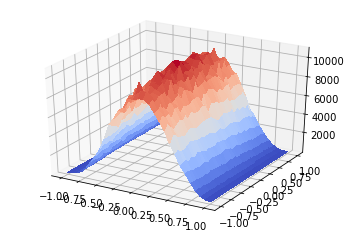

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x = np.load(r'F:\Lab\nfs\nsl\baseline_xx_imagenetv2.npy')
y = np.load(r'F:\Lab\nfs\nsl\baseline_yy_imagenetv2.npy')
z = np.load(r'F:\Lab\nfs\nsl\baseline_zz_imagenetv2.npy')


surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

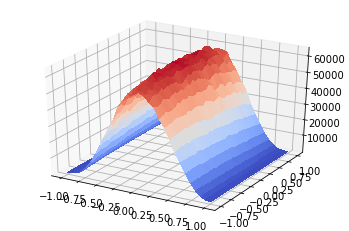

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x = np.load(r'F:\Lab\nfs\nsl\baseline_xx_imagenetv2.npy')
y = np.load(r'F:\Lab\nfs\nsl\baseline_yy_imagenetv2.npy')
z = np.load(r'F:\Lab\nfs\nsl\baseline_zz_imagenetv2.npy')


surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)